# IMPORTS

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# data
import numpy as np
import pandas as pd

# graphics
import plotly.express as px
import matplotlib.pyplot as plt

# eda
import missingno as msng
import sweetviz as sv

# stats
from pandas.plotting import autocorrelation_plot # test for seasonality
from pandas.plotting import lag_plot # test for autocorrelation
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from scipy import signal

# src
from src.data.stattests import adf_test, kpss_test

# PATHS & NAMES

In [8]:
RAW_FILENAME = "dataset.parquet"
RAWFILE_FOLDER = "../data/raw"
INTERIM_FOLDER = "../data/interim"
RAW_FILEPATH = f"{RAWFILE_FOLDER}/{RAW_FILENAME}"

EDA_REPORT_FOLDER = "../reports"

TARGET = "y"
LAG_TARGET = "x_y_lagged"

FIG_WIDTH = 15
FIG_HEIGHT = 3

# DATA

In [9]:
raw = pd.read_parquet(RAW_FILEPATH, engine='pyarrow')

not to reread file every time

In [10]:
df = raw.copy()

fix indecies

In [11]:
df.index.name = "date"
df.columns.name = None

make date a regular column

In [12]:
df['date'] = df.index
df['date'] = df['date'].dt.tz_localize(None)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6048 entries, 2023-01-16 01:00:00+01:00 to 2023-09-25 00:00:00+02:00
Data columns (total 35 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   x01         6047 non-null   float64       
 1   x02         6047 non-null   float64       
 2   x03         6047 non-null   float64       
 3   x04         6047 non-null   float64       
 4   x05         6047 non-null   float64       
 5   x06         6047 non-null   float64       
 6   x07         6047 non-null   float64       
 7   x08         6047 non-null   float64       
 8   x09         6047 non-null   float64       
 9   x10         6047 non-null   float64       
 10  x11         6047 non-null   float64       
 11  x12         6047 non-null   float64       
 12  x13         6047 non-null   float64       
 13  x14         6047 non-null   float64       
 14  x15         6047 non-null   float64       
 15  x16         6047 non-nul

In [14]:
df.head()

x01      x02     x03  x04  x05     x06    x07  \
date                                                                          
2023-01-16 01:00:00+01:00  4277.0  15501.0  2512.0  0.0  0.0  6197.0  140.0   
2023-01-16 02:00:00+01:00  4130.0  15089.0  2422.0  0.0  0.0  5657.0  125.0   
2023-01-16 03:00:00+01:00  3999.0  14962.0  2438.0  0.0  0.0  5135.0  110.0   
2023-01-16 04:00:00+01:00  3965.0  15026.0  2426.0  0.0  0.0  4735.0   98.0   
2023-01-16 05:00:00+01:00  4104.0  15470.0  2519.0  0.0  0.0  4420.0   94.0   

                              x08        x09        x10  ...    x26  x27  \
date                                                     ...               
2023-01-16 01:00:00+01:00  1617.0  87.885115  60.010055  ...  37.11  0.0   
2023-01-16 02:00:00+01:00  1587.0  90.430952  62.721417  ...  32.79  0.0   
2023-01-16 03:00:00+01:00  1548.0  89.991216  56.103107  ...  40.00  0.0   
2023-01-16 04:00:00+01:00  1552.0  90.925069  63.304305  ...  39.69  0.0   
2023-01-16 05:00:00+01:00  1629.0  94.905936  87.005404  ...  42.24  0.0   

                             x28     x29      x30  x_y_lagged  x_z_lagged  \
date                                                                        
2023-01-16 01:00:00+01:00  50.00  5845.0  15046.0       95.97       25.24   
2023-01-16 02:00:00+01:00  44.71  6259.0  16741.0       95.00       45.86   
2023-01-16 03:00:00+01:00  51.00  6176.0  17814.0       95.00       21.12   
2023-01-16 04:00:00+01:00  56.12  6632.0  19696.0       87.05        5.42   
2023-01-16 05:00:00+01:00  55.47  6753.0  21700.0       93.27        4.18   

                               y      z                date  
date                                                         
2023-01-16 01:00:00+01:00  66.99  60.01 2023-01-16 01:00:00  
2023-01-16 02:00:00+01:00  63.03  60.01 2023-01-16 02:00:00  
2023-01-16 03:00:00+01:00  66.85  62.72 2023-01-16 03:00:00  
2023-01-16 04:00:00+01:00  64.96  56.10 2023-01-16 04:00:00  
2023-01-16 05:00:00+01:00  63.42  63.30 2023-01-16 05:00:00  

[5 rows x 35 columns]

# MISSINGS

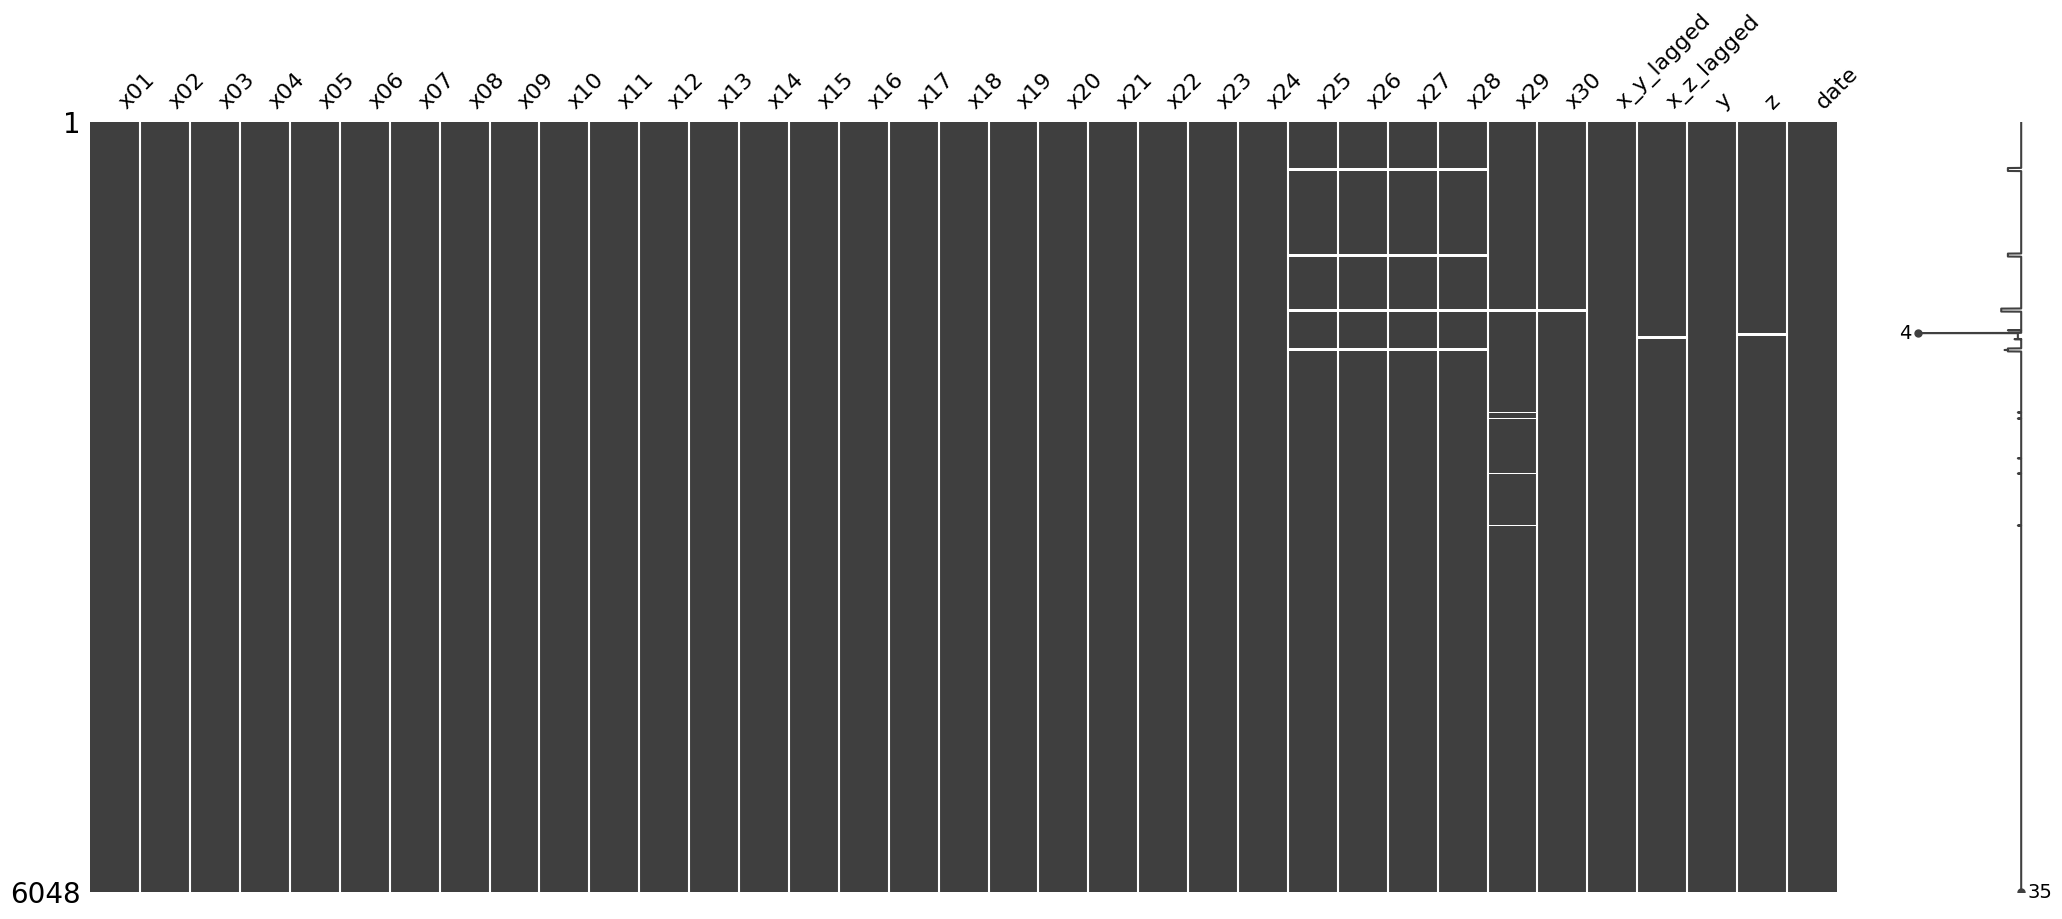

In [15]:
_ = msng.matrix(df)

## missing target

why?

In [16]:
mask_missing_targets = df[TARGET].isna() | df[LAG_TARGET].isna() 
df[mask_missing_targets]

x01      x02     x03  x04  x05     x06    x07  \
date                                                                          
2023-03-26 03:00:00+02:00     NaN      NaN     NaN  NaN  NaN     NaN    NaN   
2023-03-28 02:00:00+02:00  4340.0  16753.0  2552.0  0.0  0.0  2641.0  144.0   

                              x08        x09        x10  ...   x26  x27   x28  \
date                                                     ...                    
2023-03-26 03:00:00+02:00     NaN        NaN        NaN  ...   NaN  NaN   NaN   
2023-03-28 02:00:00+02:00  1489.0  86.226633  84.678745  ...  8.29  0.0  8.55   

                              x29      x30  x_y_lagged  x_z_lagged      y  \
date                                                                        
2023-03-26 03:00:00+02:00     NaN      NaN       85.01       46.14    NaN   
2023-03-28 02:00:00+02:00  5659.0  15275.0         NaN       93.28  92.23   

                               z                date  
date                                                  
2023-03-26 03:00:00+02:00    NaN 2023-03-26 03:00:00  
2023-03-28 02:00:00+02:00  87.02 2023-03-28 02:00:00  

[2 rows x 35 columns]

hot fix to conduct MVA

In [17]:
nomiss = df[~mask_missing_targets]

# TIMESERIES ANALYSIS

## stationarity
### Augmented Dickey Fuller test

In [18]:
adf_test(nomiss[TARGET])

Results of Augmented Dickey-Fuller test:
H0 is rejected (time series is stationary)
Test Statistic                -6.433830e+00
p-value                        1.671791e-08
#Lags Used                     3.400000e+01
Number of Observations Used    6.011000e+03
dtype: float64


### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [21]:
kpss_test(nomiss[TARGET])

Results of KPSS Test:
Test Statistic     4.652796
p-value            0.010000
Lags Used         40.000000
dtype: float64
H0 is rejected (time series is non-stationary)


c:\_root\_personal\_repos\financial-timeseries\src\data\stattests.py:57: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  Returns:


### Augmented Dickey Fuller test
- H0: there is a unit root
- H1: no unit root

## decomposition

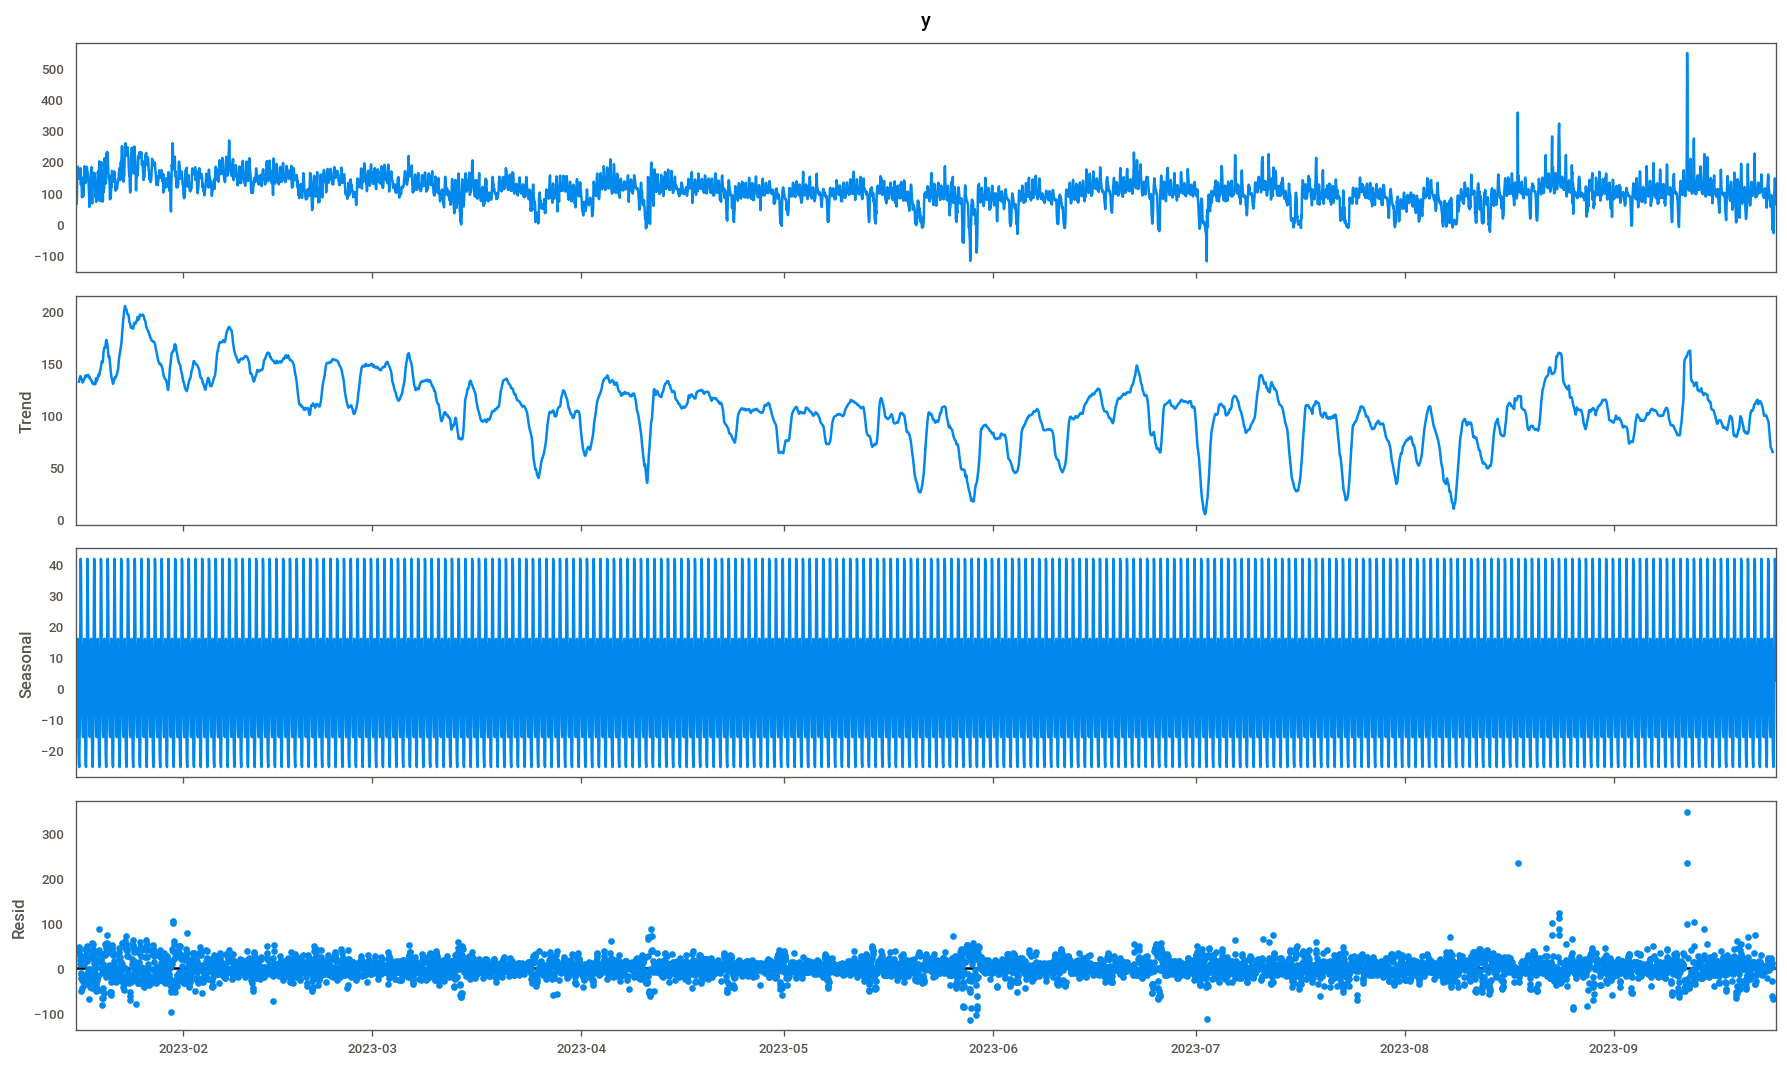

In [123]:
decompose = seasonal_decompose(x=nomiss[TARGET], model='additive')
plt.rcParams.update({'figure.figsize': (FIG_WIDTH, FIG_HEIGHT*3)})
decompose.plot()
plt.show()

## detrend

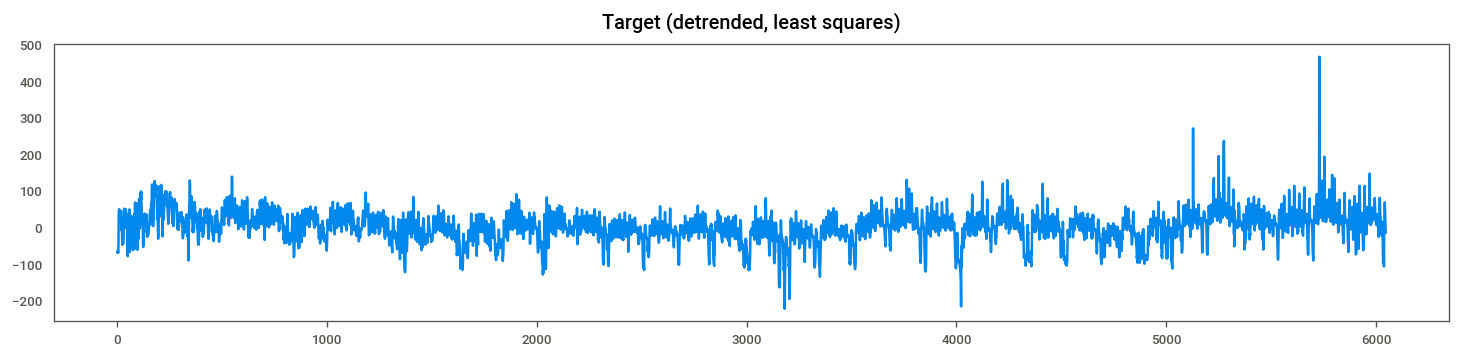

In [136]:
detrended = signal.detrend(nomiss[TARGET].values)
plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
plt.plot(detrended)
plt.title("Target (detrended, least squares)")
plt.show()

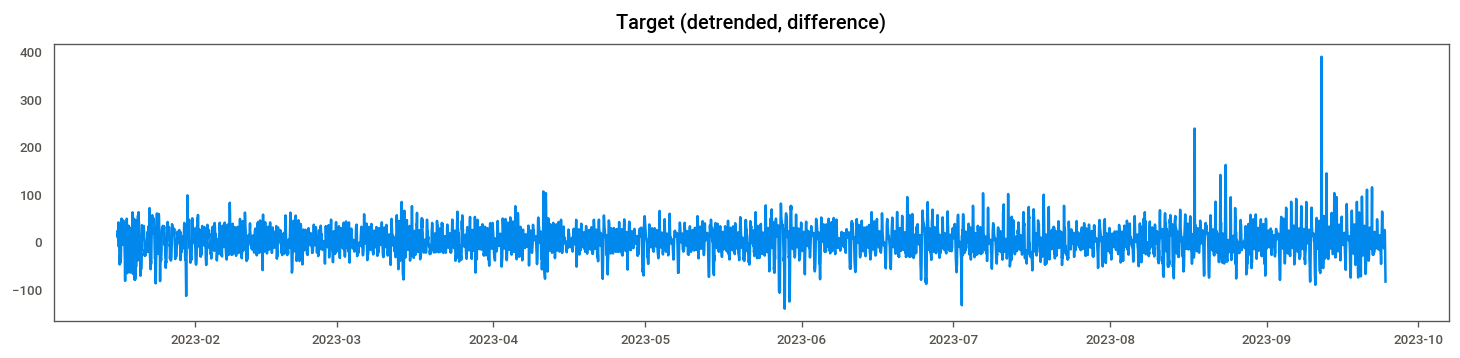

In [137]:
detrended = nomiss[TARGET].values - decompose.trend
plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
plt.plot(detrended)
plt.title("Target (detrended, difference)")
plt.show()

## deseasonilize

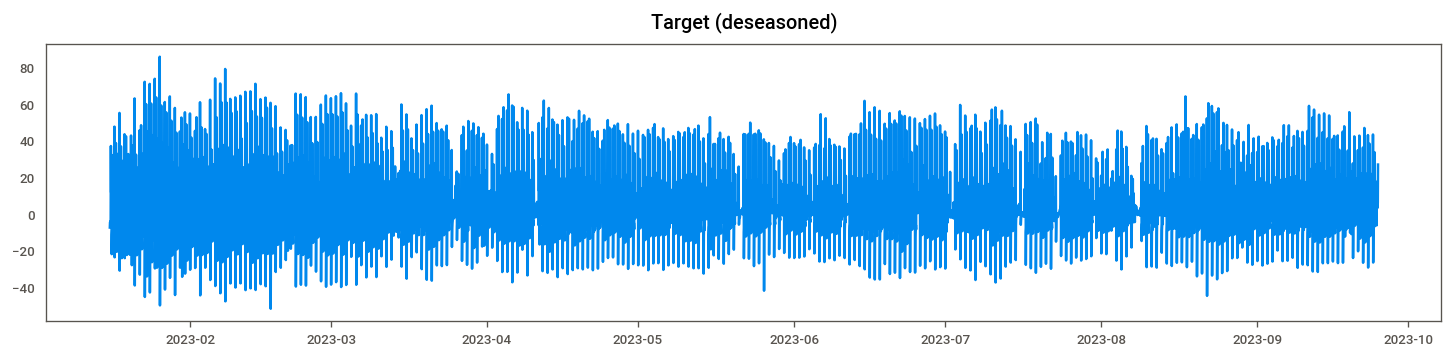

In [138]:
deseason = nomiss[TARGET].values / decompose.seasonal
plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
plt.plot(deseason)
plt.title("Target (deseasoned)")
plt.show()

## autocorrelation

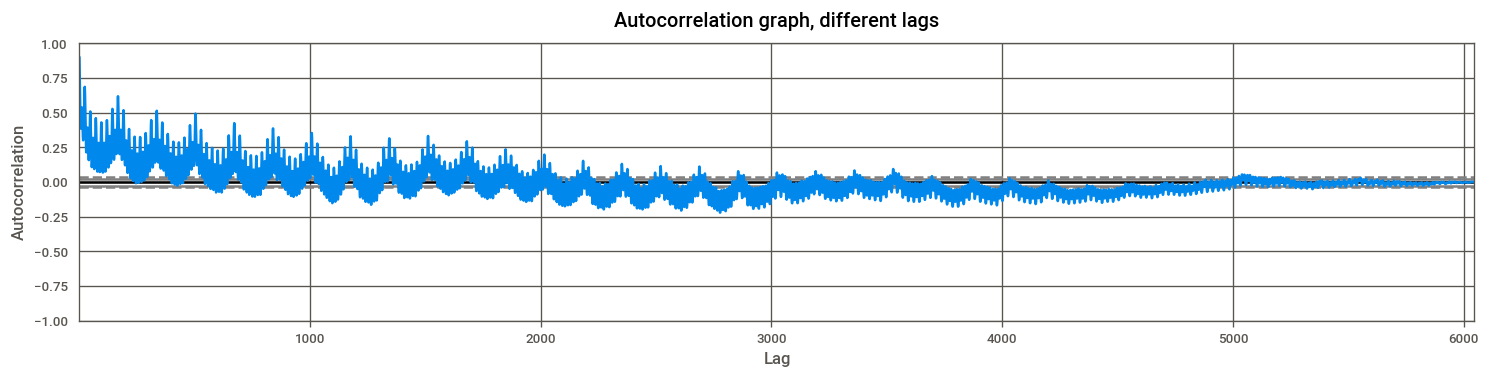

In [124]:
plt.rcParams.update({'figure.figsize':(FIG_WIDTH, FIG_HEIGHT), 'figure.dpi':120})
autocorrelation_plot(nomiss[TARGET].tolist())
plt.title("Autocorrelation graph, different lags")
plt.show()

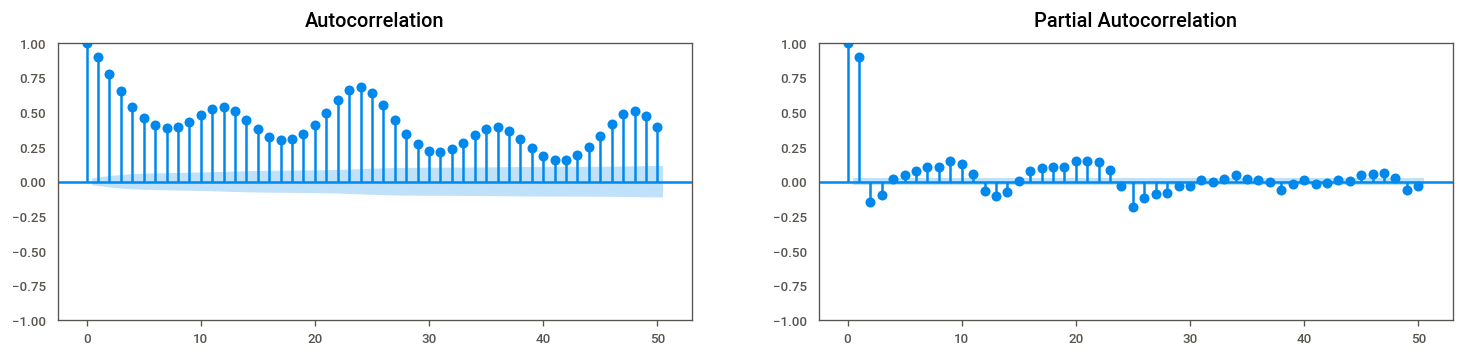

In [125]:
fig, axes = plt.subplots(1,2, figsize=(FIG_WIDTH, FIG_HEIGHT))
plot_acf(nomiss[TARGET].tolist(), lags=50, ax=axes[0]);
plot_pacf(nomiss[TARGET].tolist(), lags=50, ax=axes[1]);

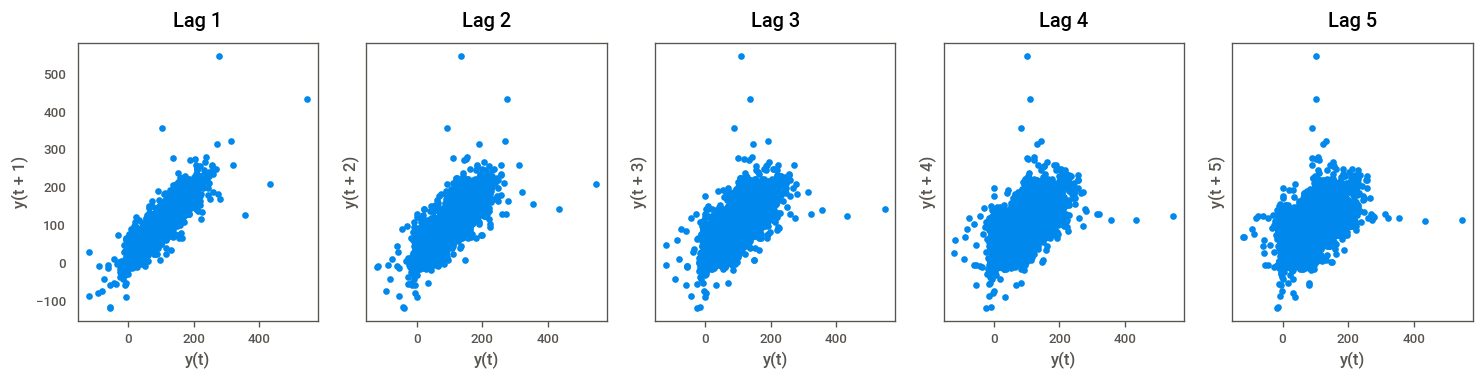

In [133]:
n_lags = 5
fig, axes = plt.subplots(1, n_lags, figsize=(FIG_WIDTH, FIG_HEIGHT), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()[:n_lags], start=1):
    lag_plot(nomiss[TARGET], lag=i, ax=ax)
    ax.set_title('Lag ' + str(i))  
plt.show()

In [147]:
_ = grangercausalitytests(nomiss[[TARGET, LAG_TARGET]], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5513  , p=0.0035  , df_denom=6042, df_num=1
ssr based chi2 test:   chi2=8.5556  , p=0.0034  , df=1
likelihood ratio test: chi2=8.5495  , p=0.0035  , df=1
parameter F test:         F=8.5513  , p=0.0035  , df_denom=6042, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=112.4396, p=0.0000  , df_denom=6039, df_num=2
ssr based chi2 test:   chi2=225.0655, p=0.0000  , df=2
likelihood ratio test: chi2=220.9762, p=0.0000  , df=2
parameter F test:         F=112.4396, p=0.0000  , df_denom=6039, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=85.3454 , p=0.0000  , df_denom=6036, df_num=3
ssr based chi2 test:   chi2=256.3331, p=0.0000  , df=3
likelihood ratio test: chi2=251.0455, p=0.0000  , df=3
parameter F test:         F=85.3454 , p=0.0000  , df_denom=6036, df_num=3


# MULTIVARIATE ANALYSIS

In [13]:
report = sv.analyze(nomiss, target_feat=TARGET)

                                             |          | [  0%]   00:00 -> (? left)

In [14]:
report.show_html(f"{EDA_REPORT_FOLDER}/eda.html", open_browser=False)

Report ../reports/eda.html was generated.



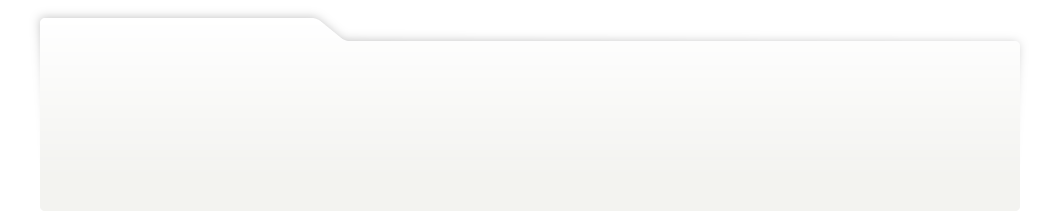
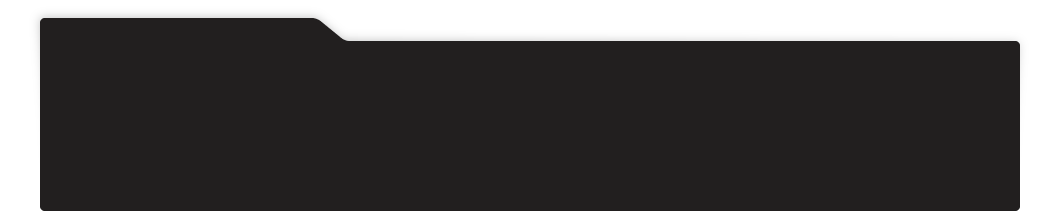
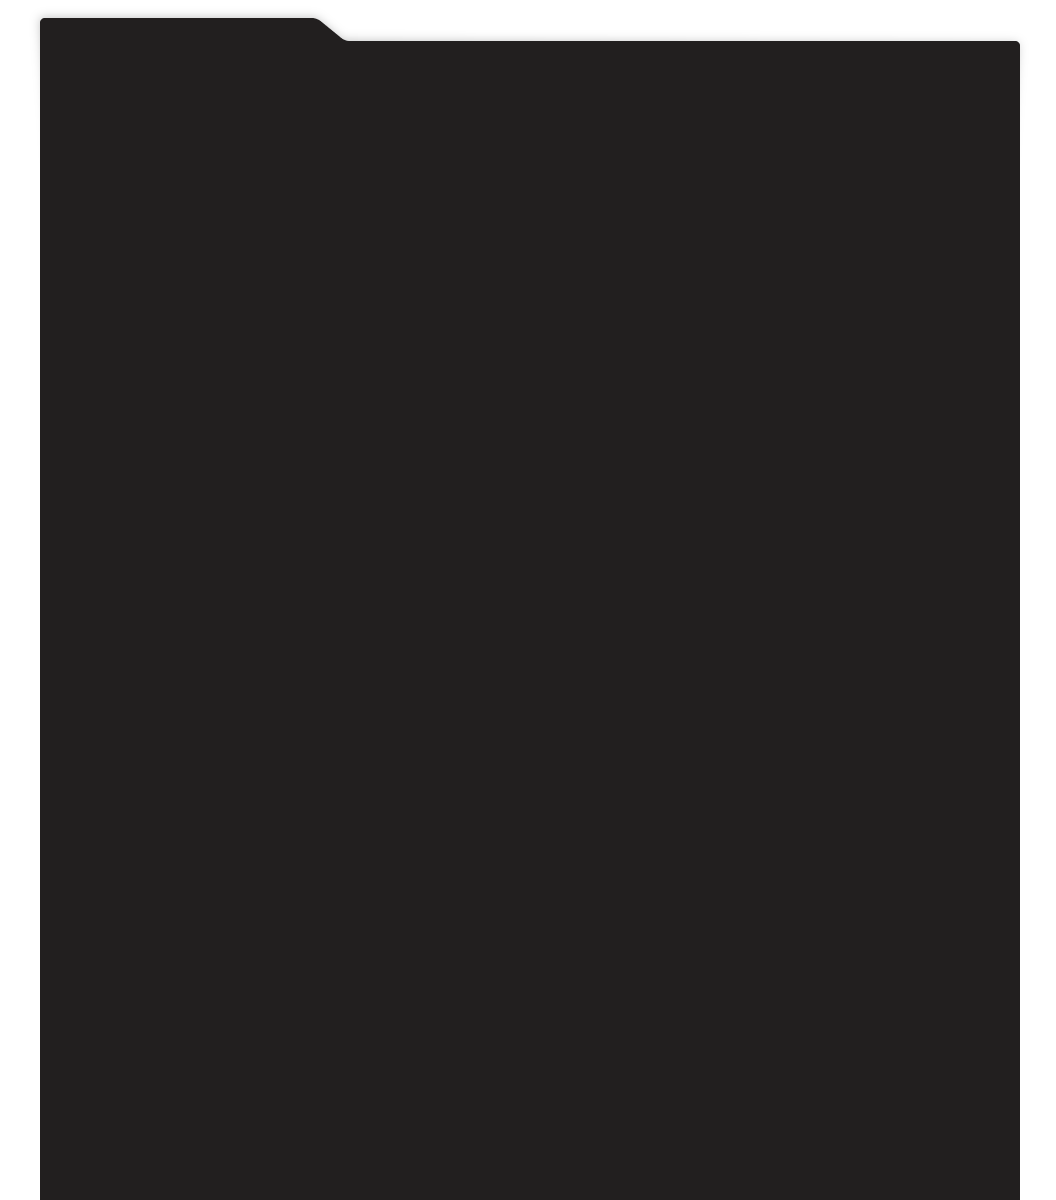
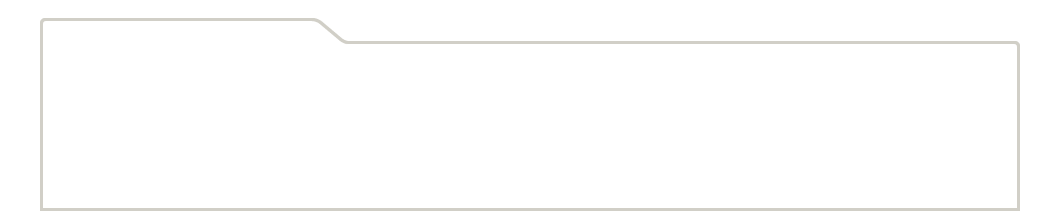
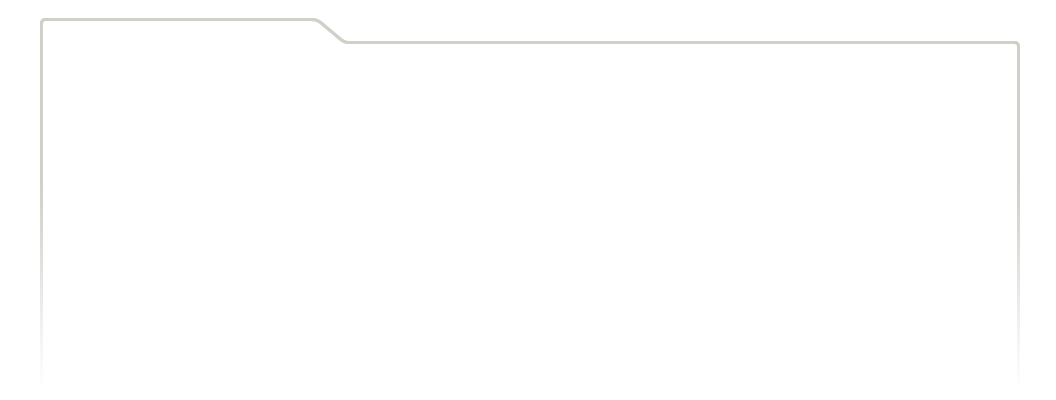
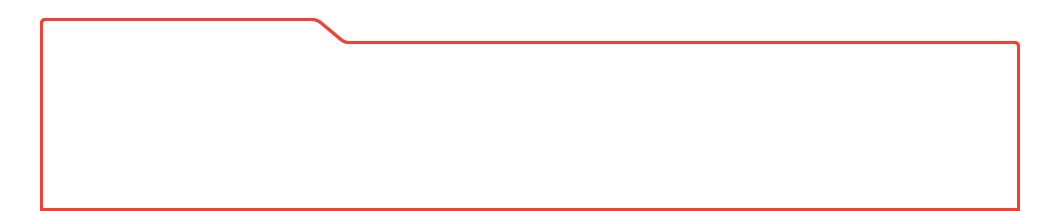
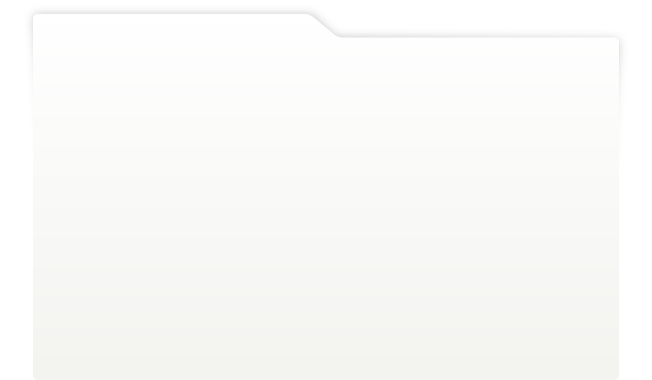
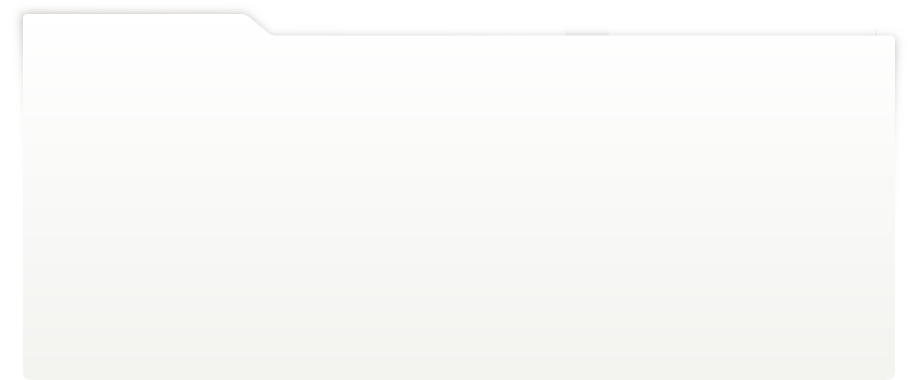
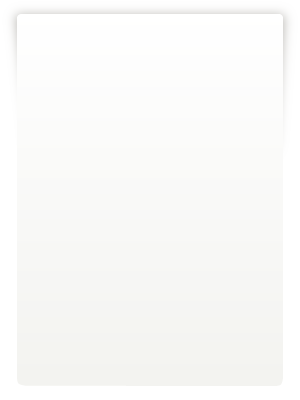
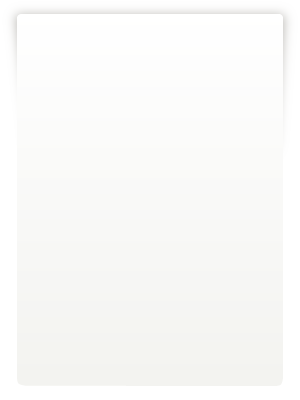
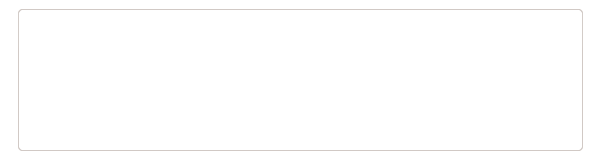
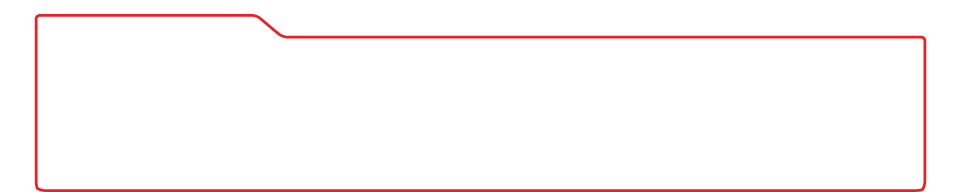
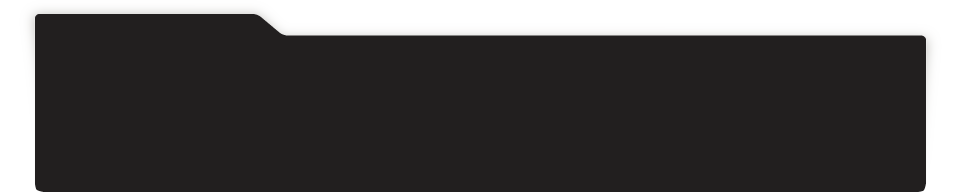
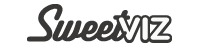
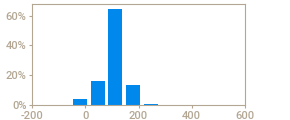
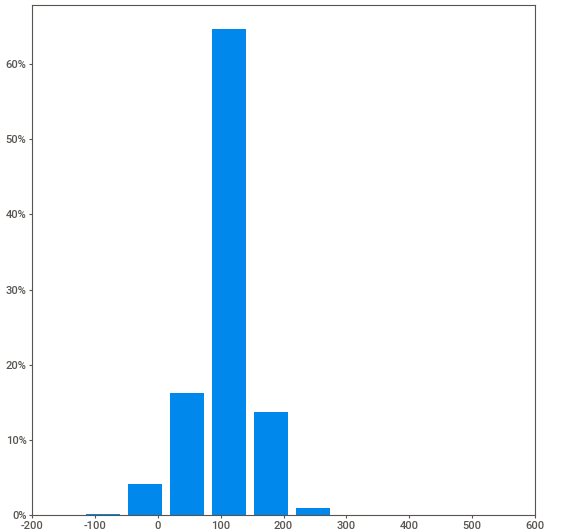
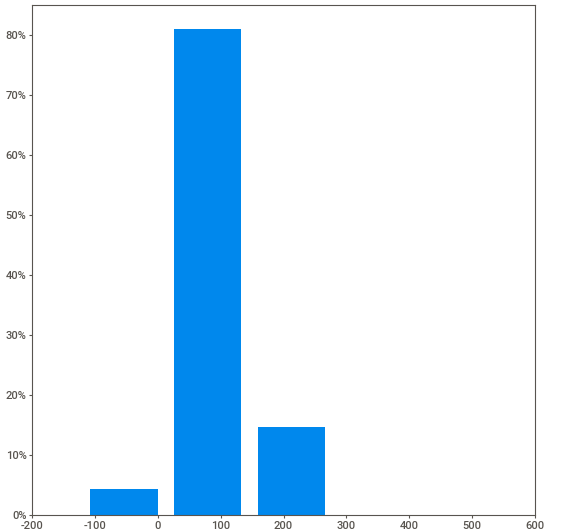
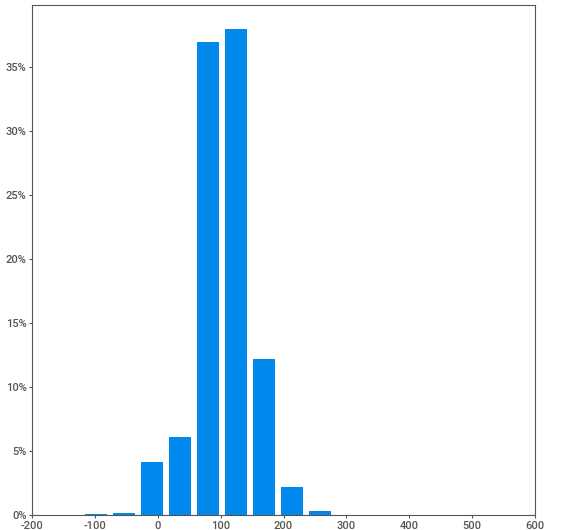
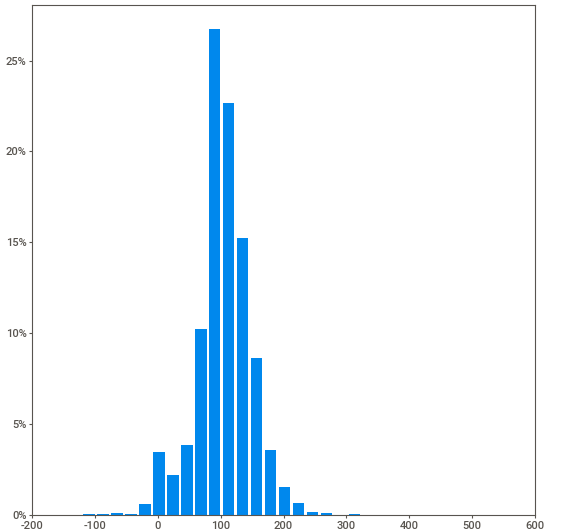
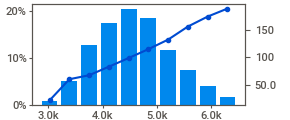
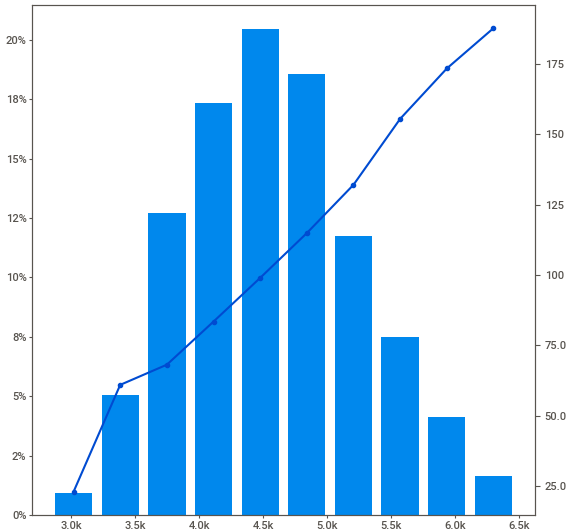
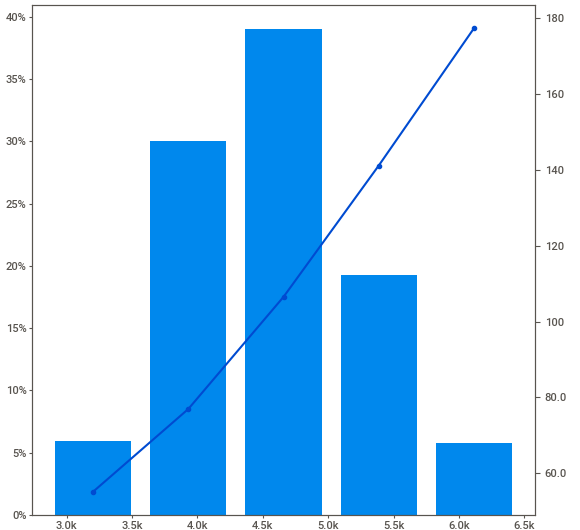
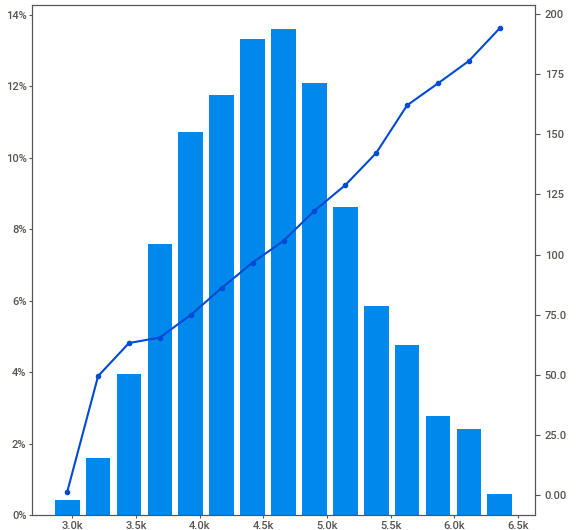
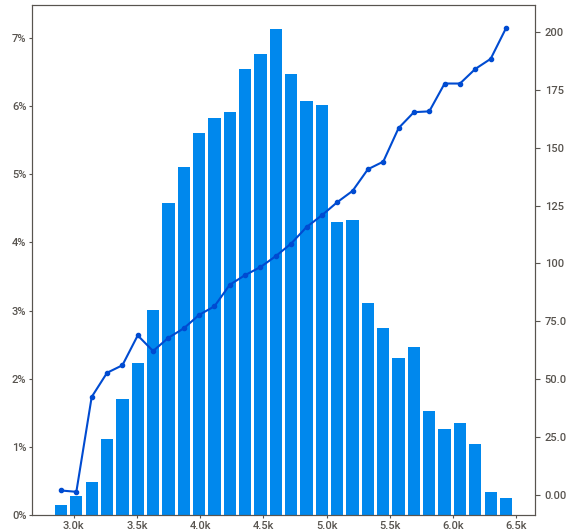
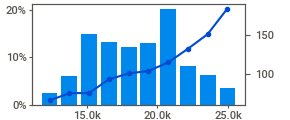
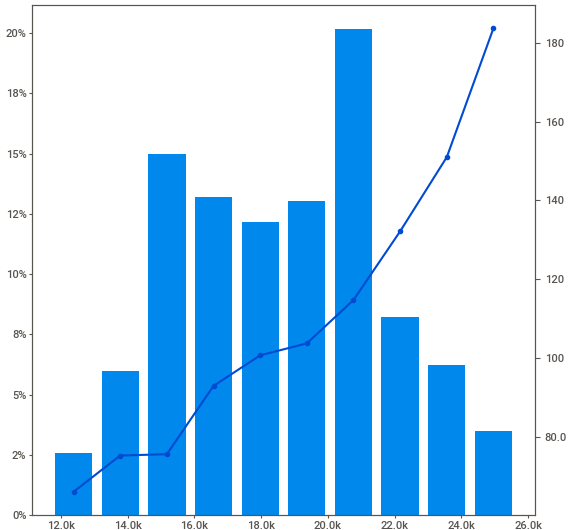
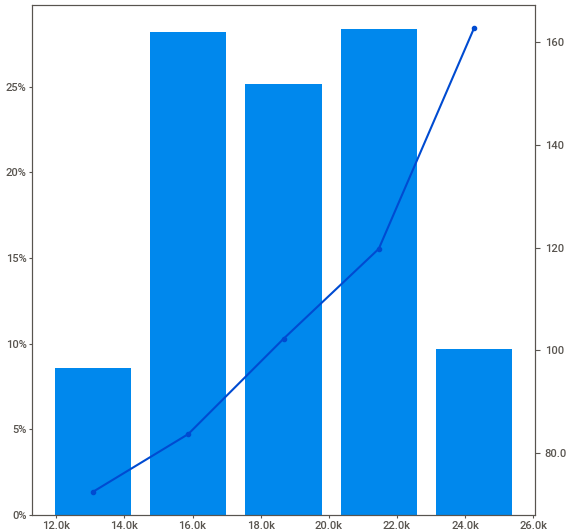
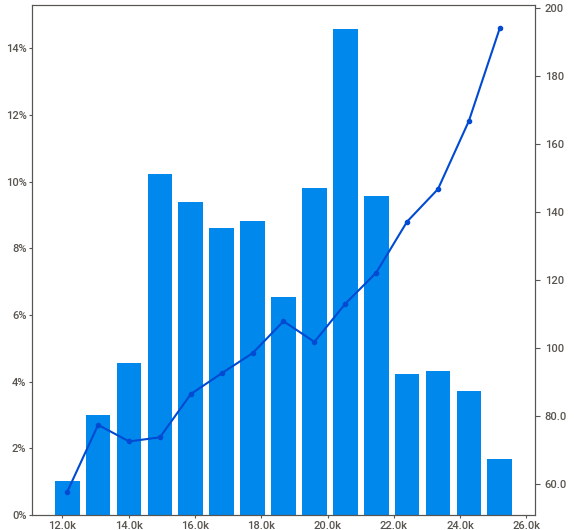
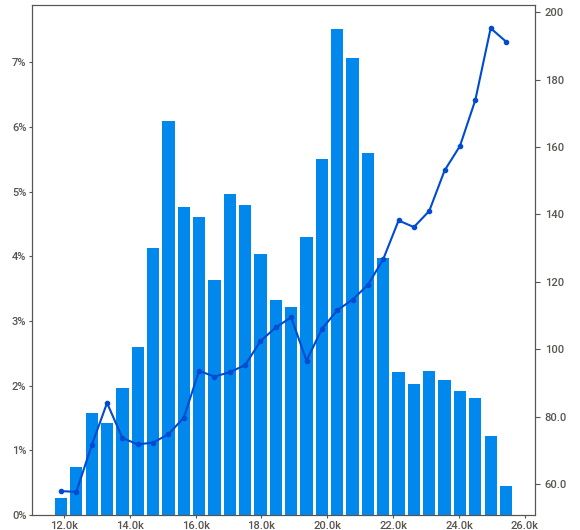
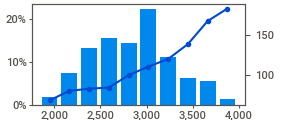
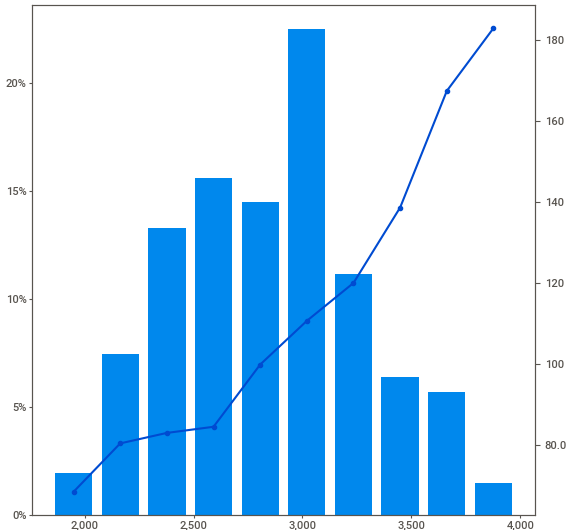
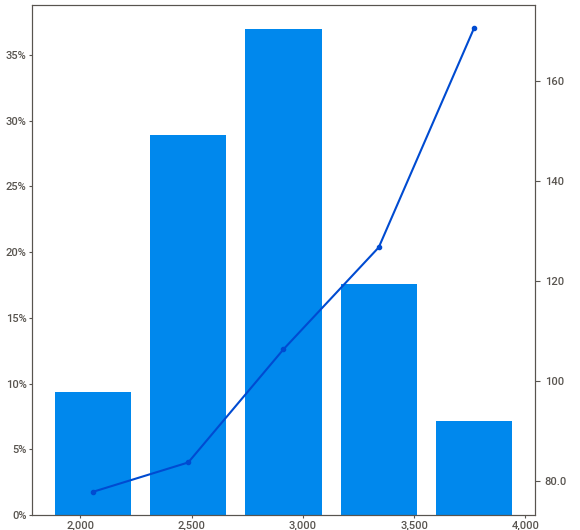
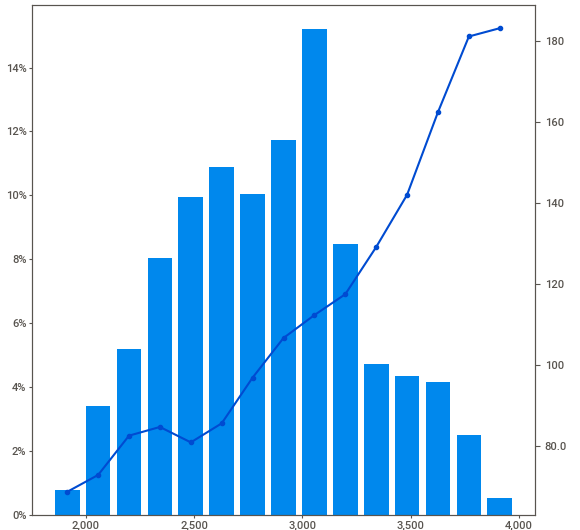
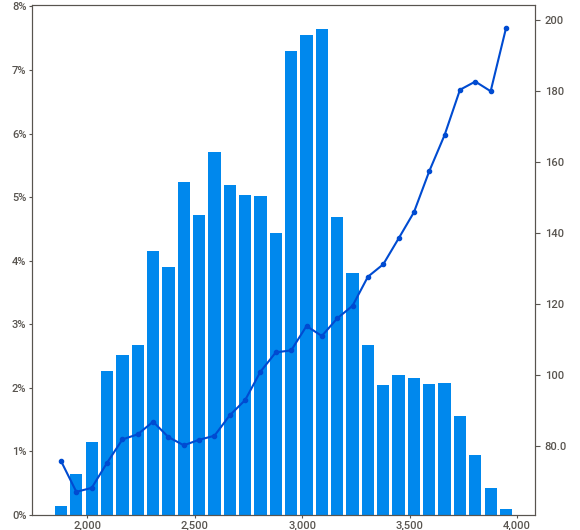
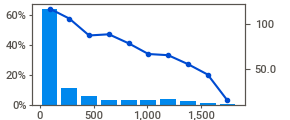
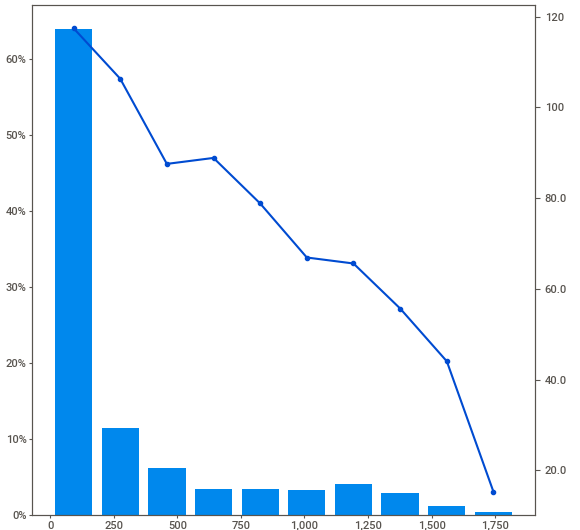
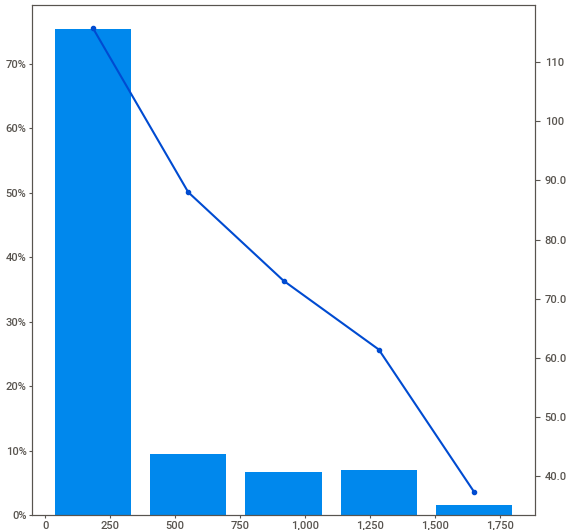
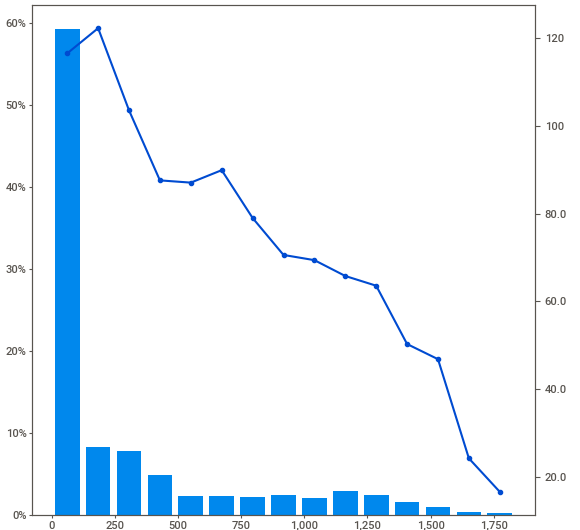
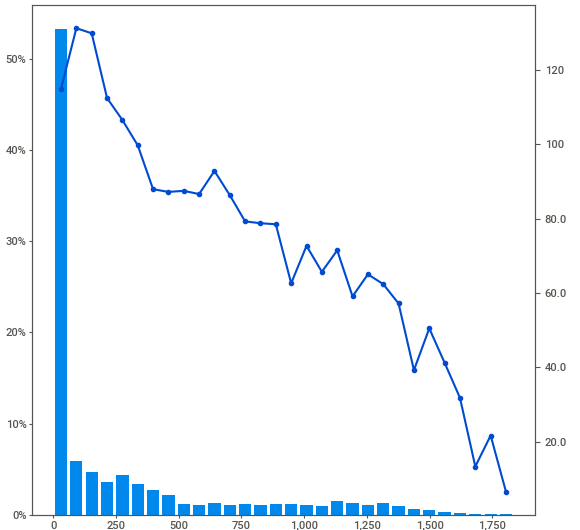
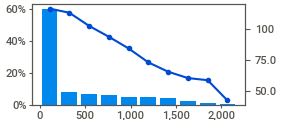
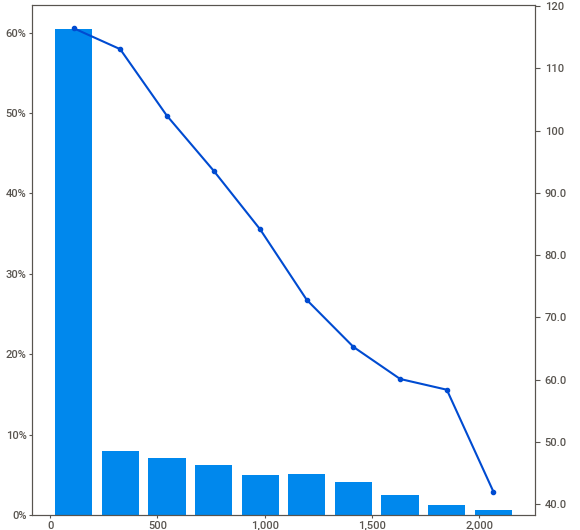
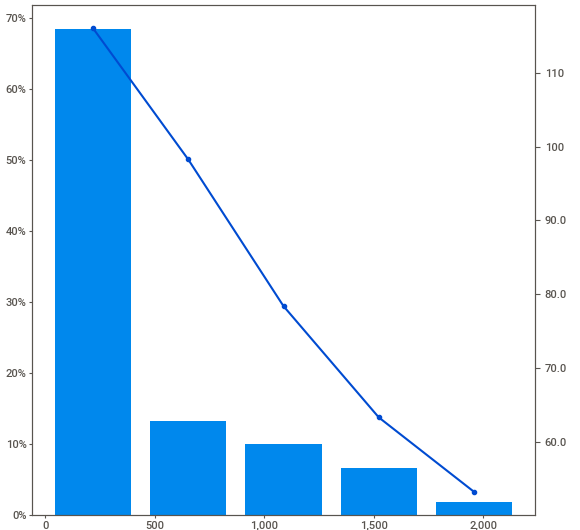
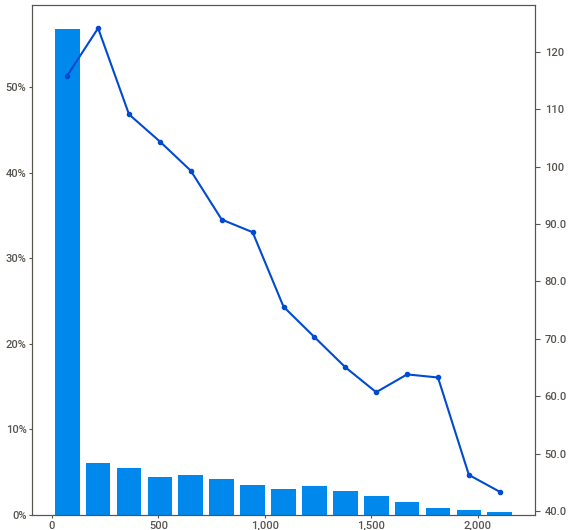
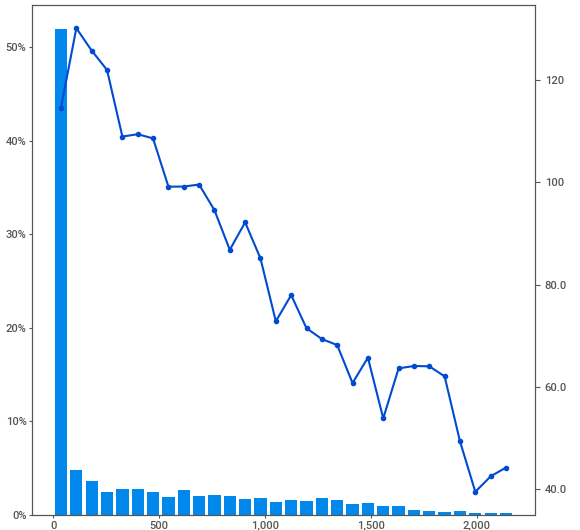
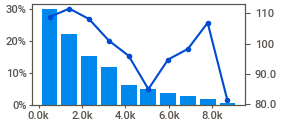
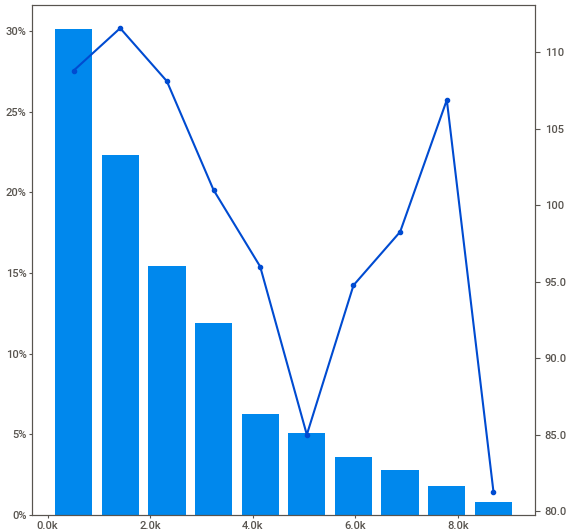
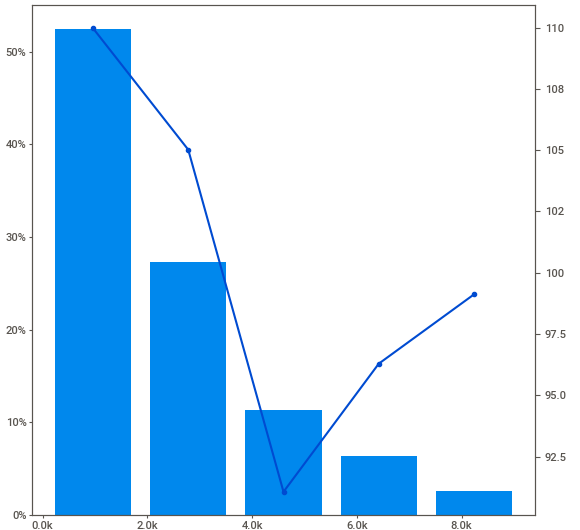
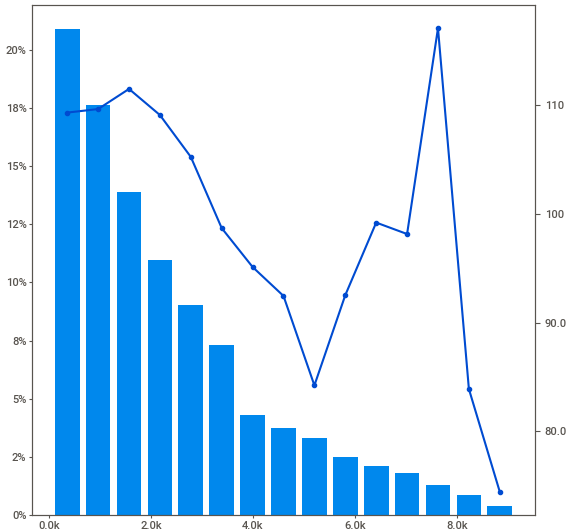
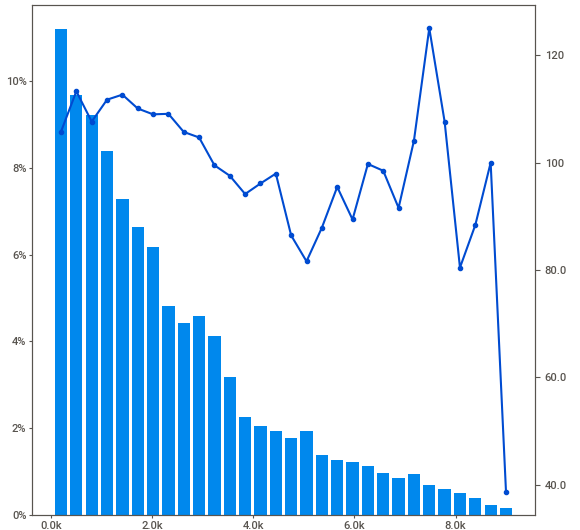
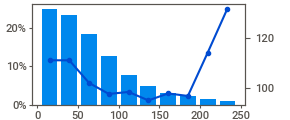
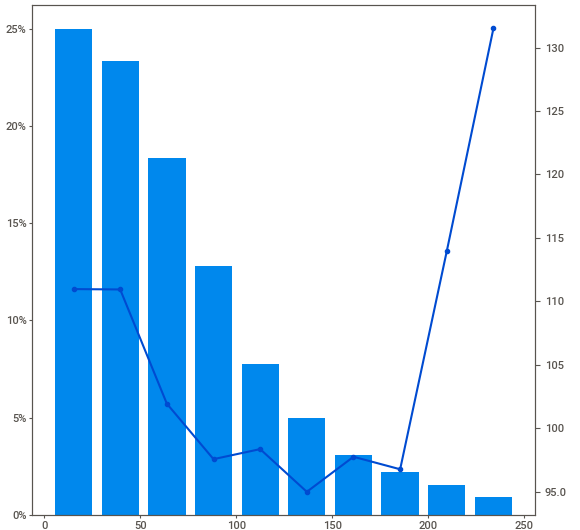
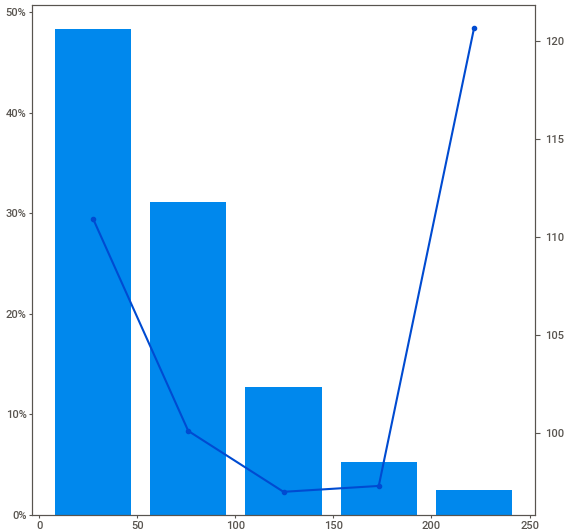
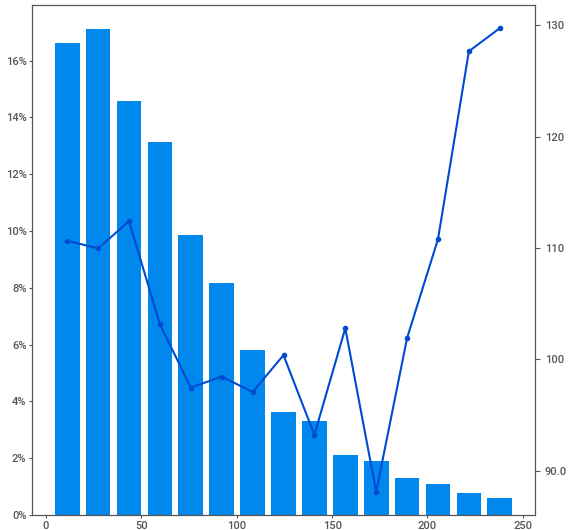
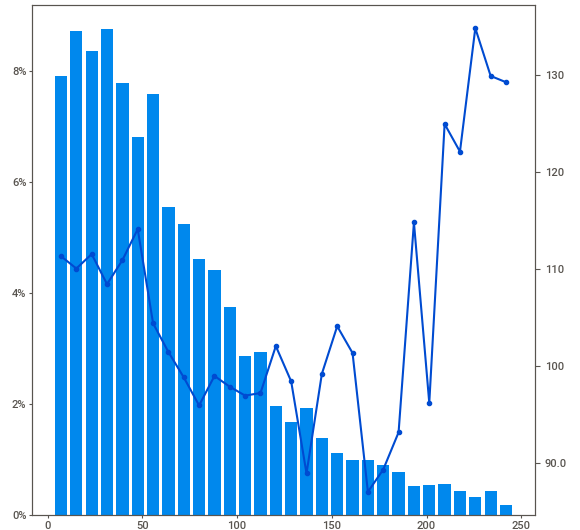
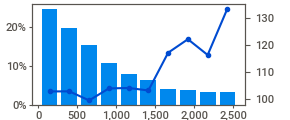
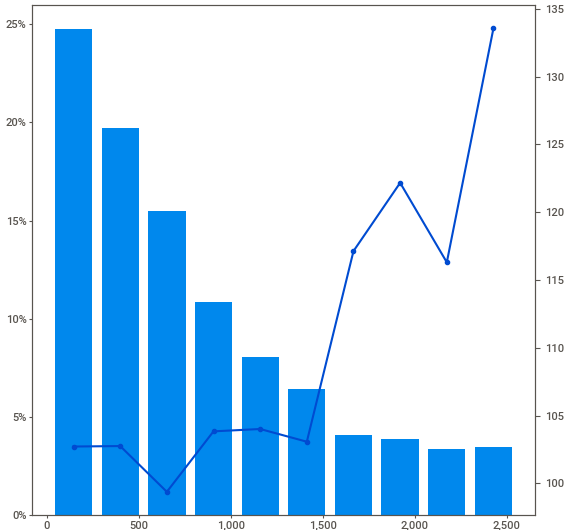
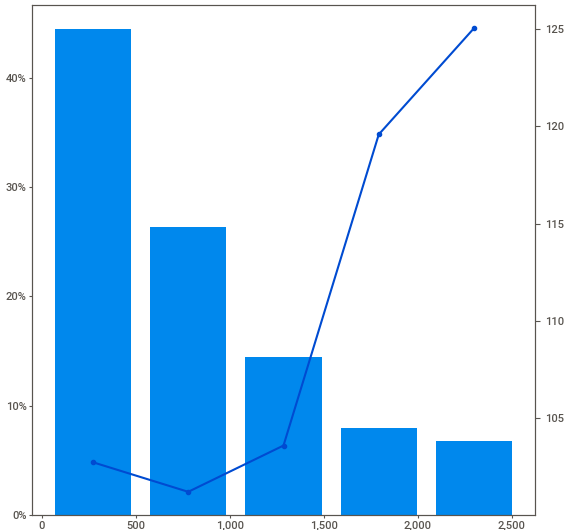
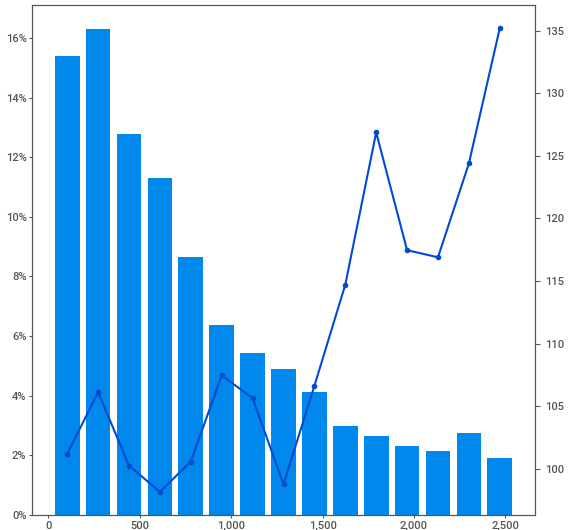
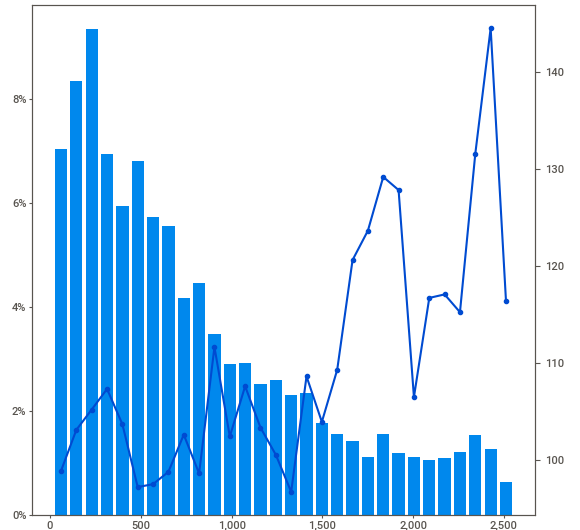
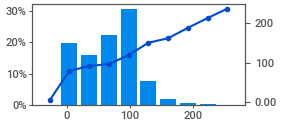
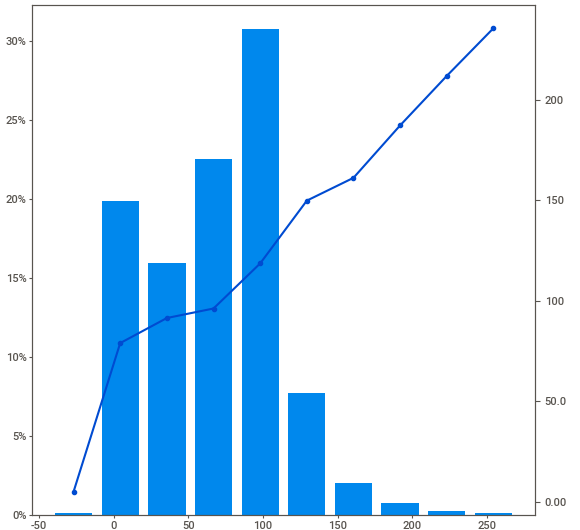
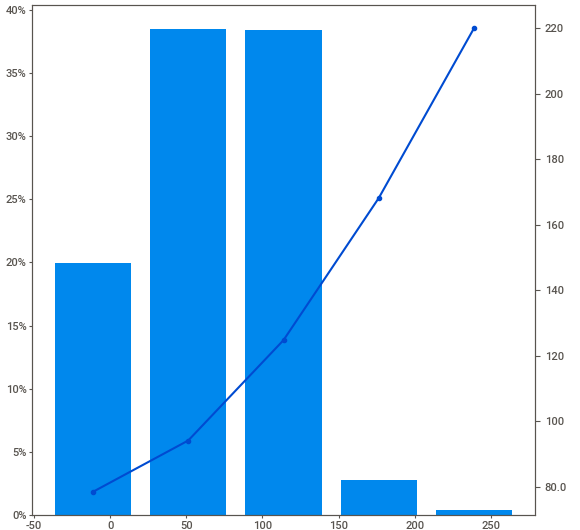
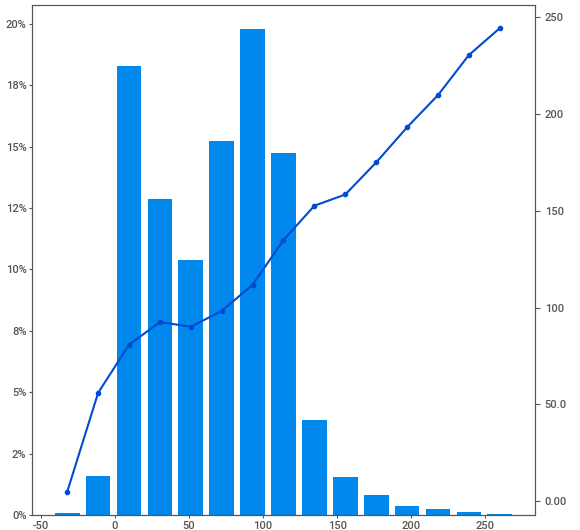
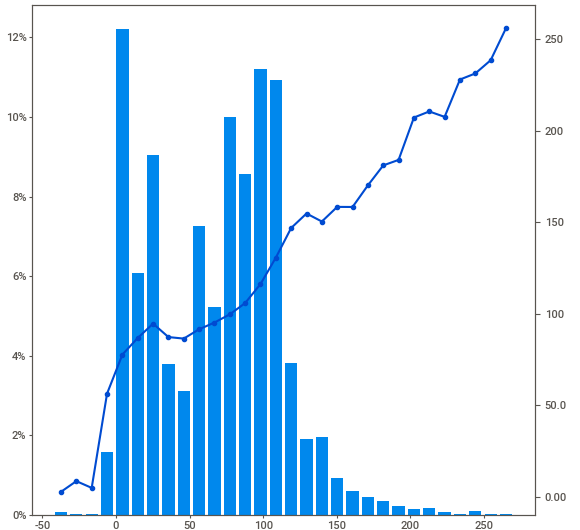
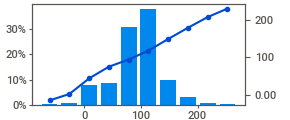
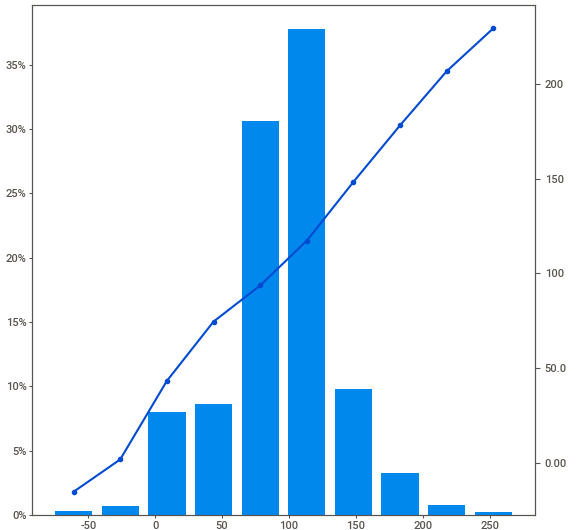
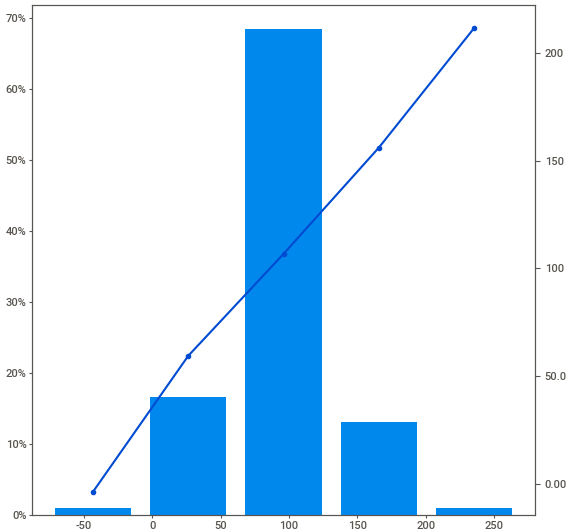
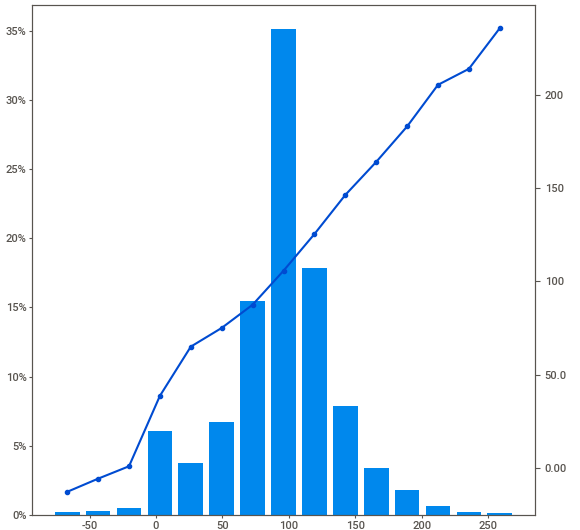
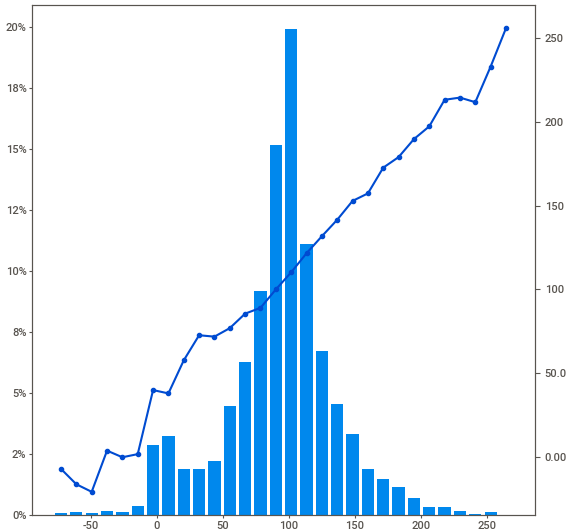
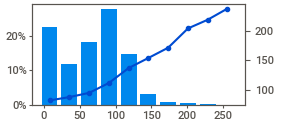
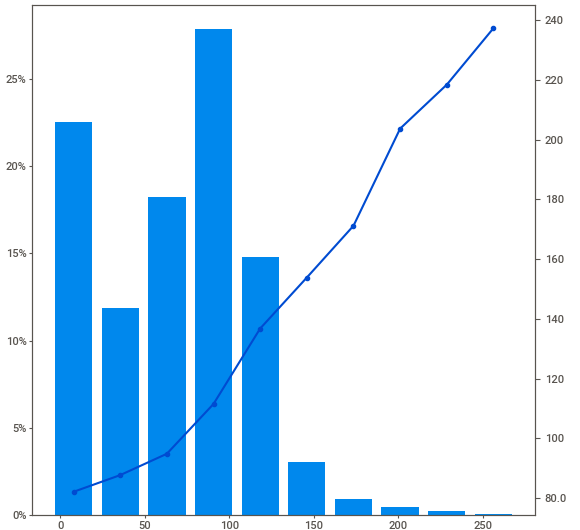
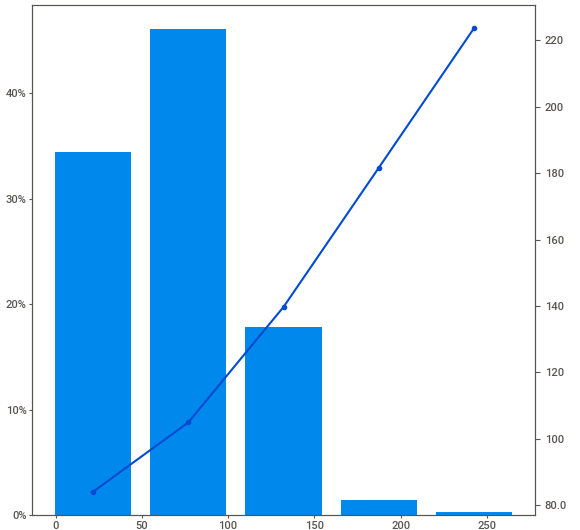
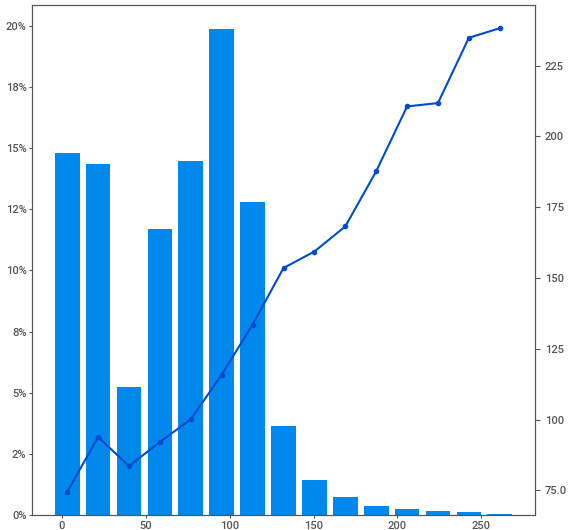
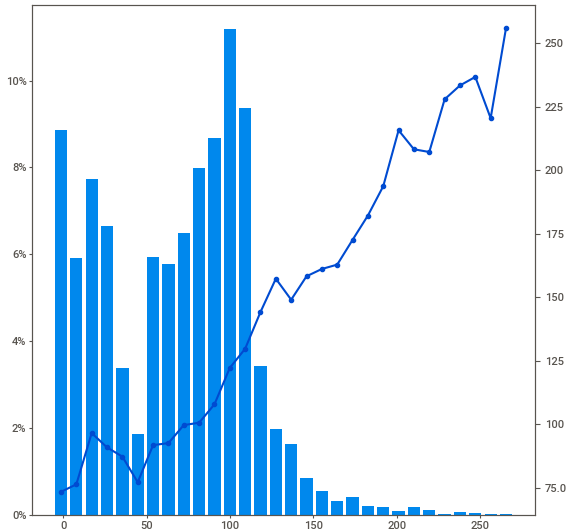
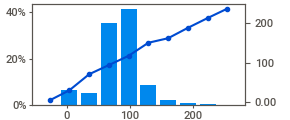
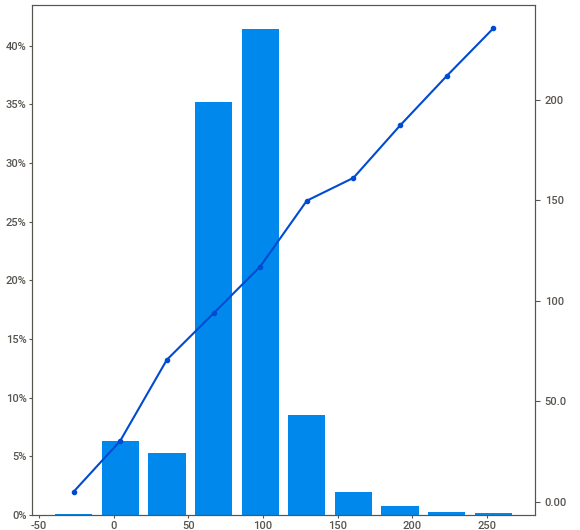
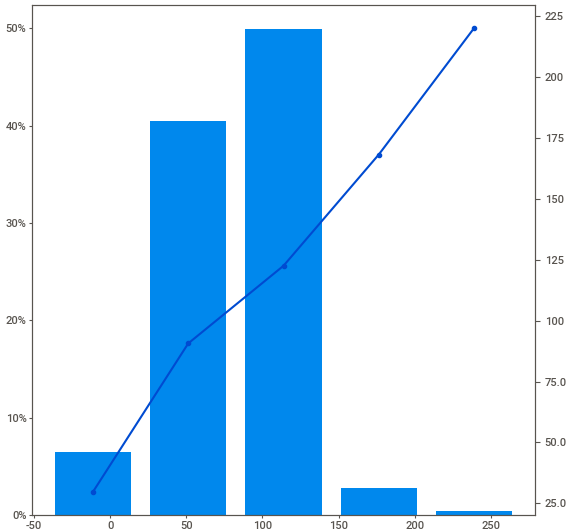
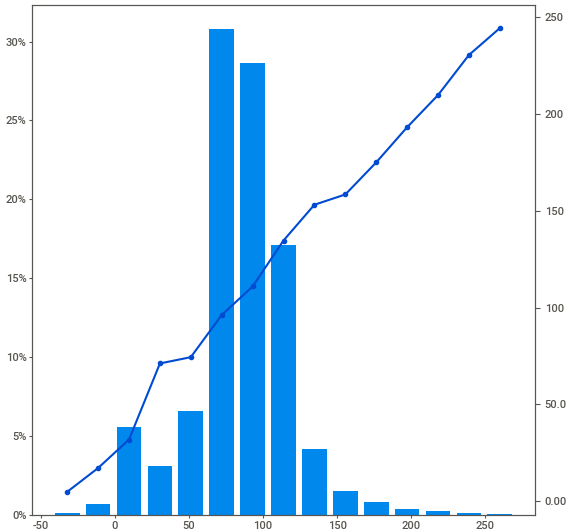
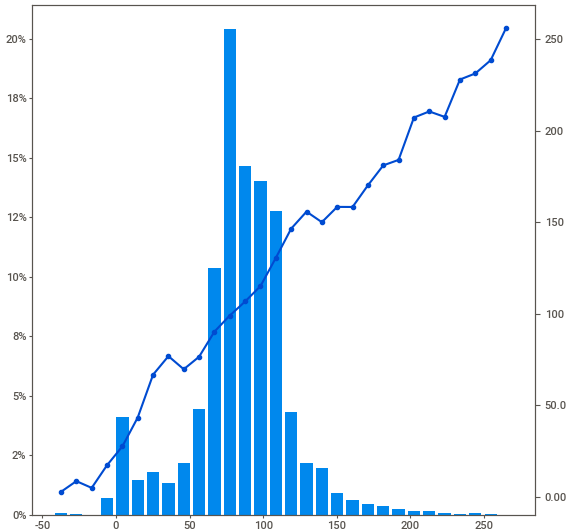
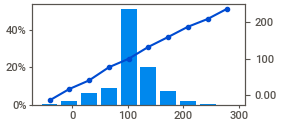
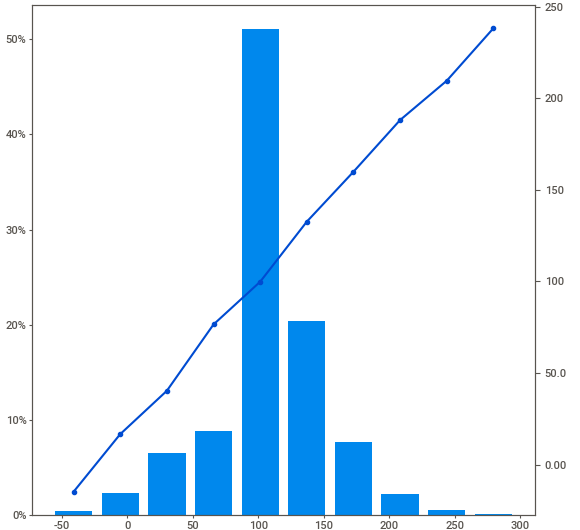
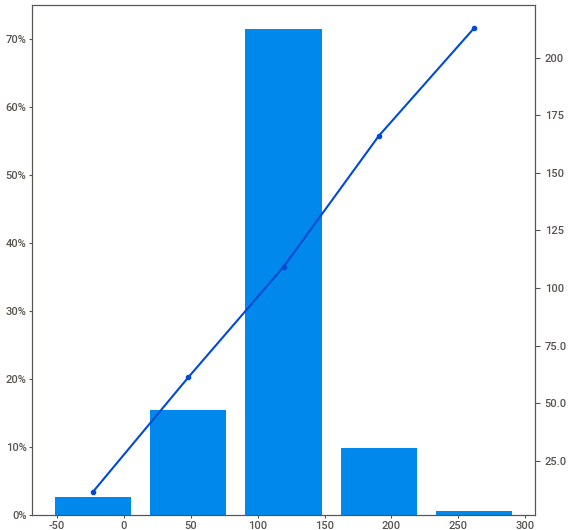
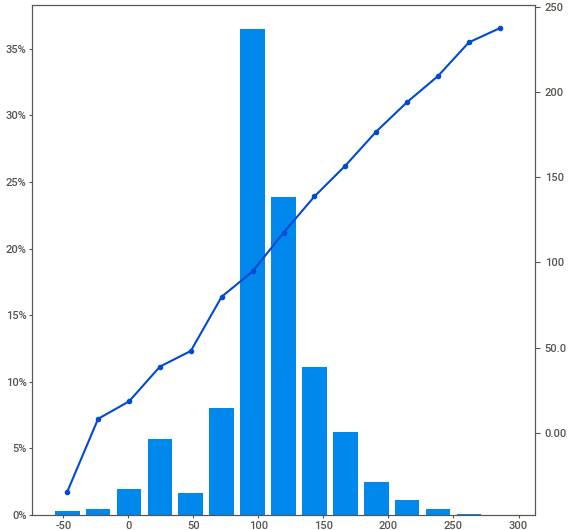
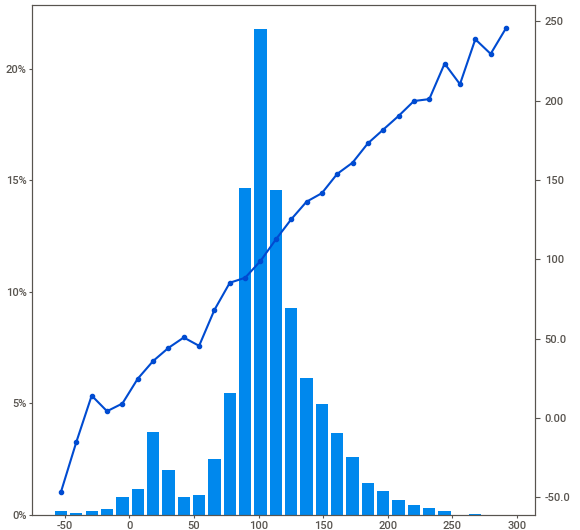
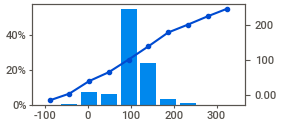
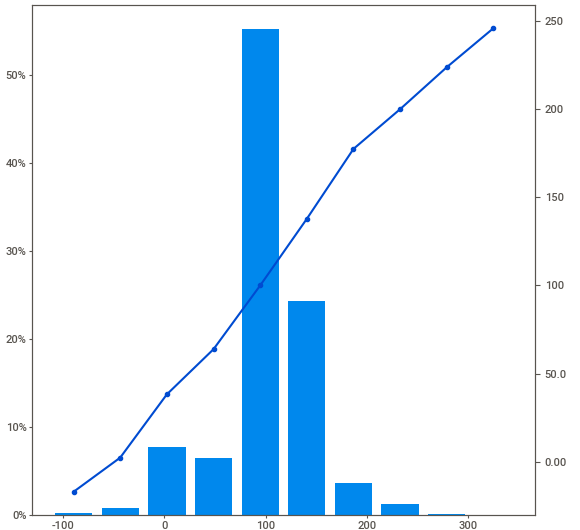
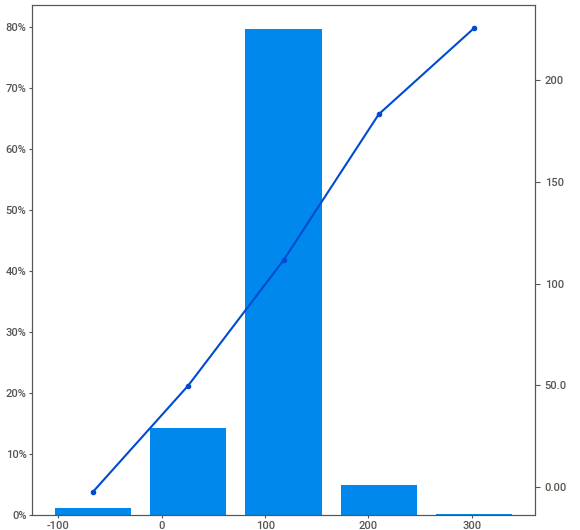
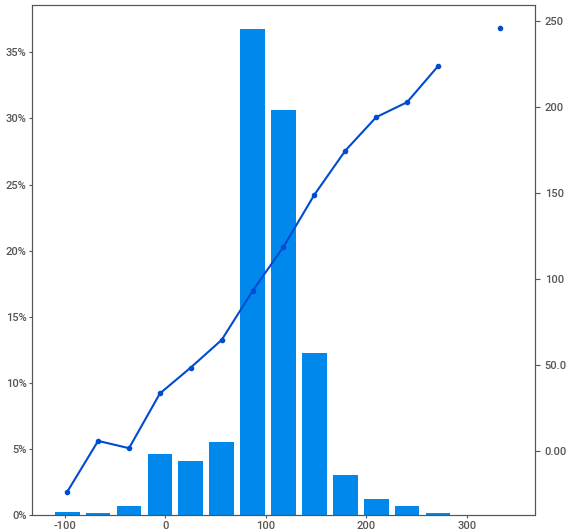
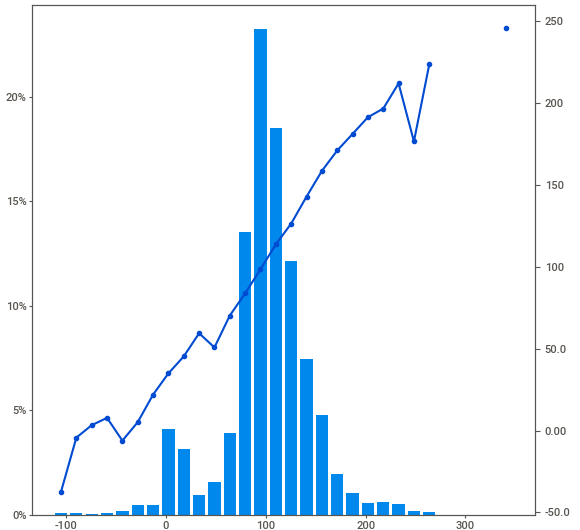
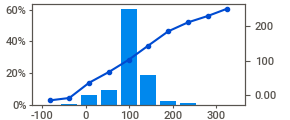
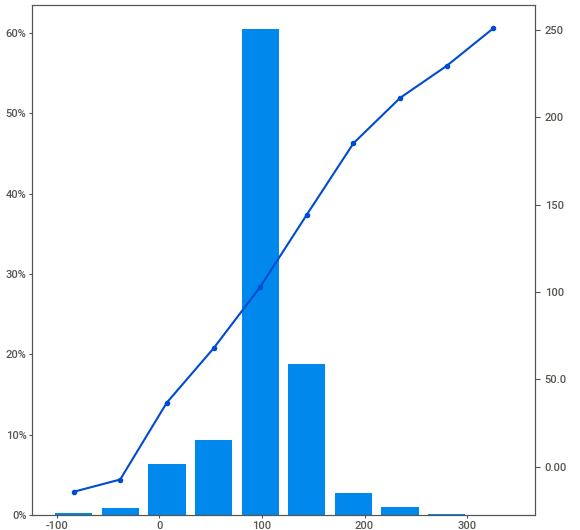
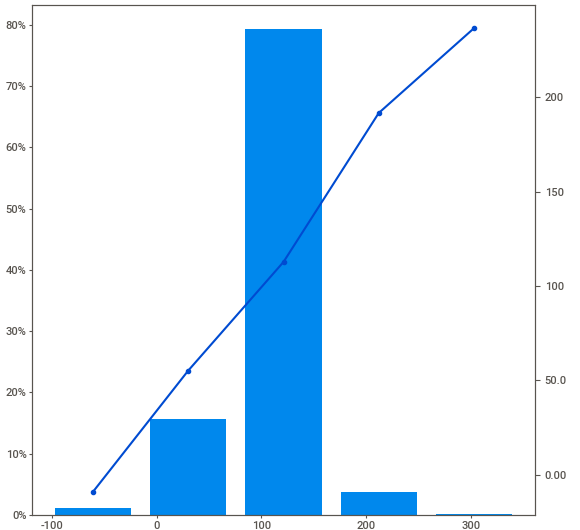
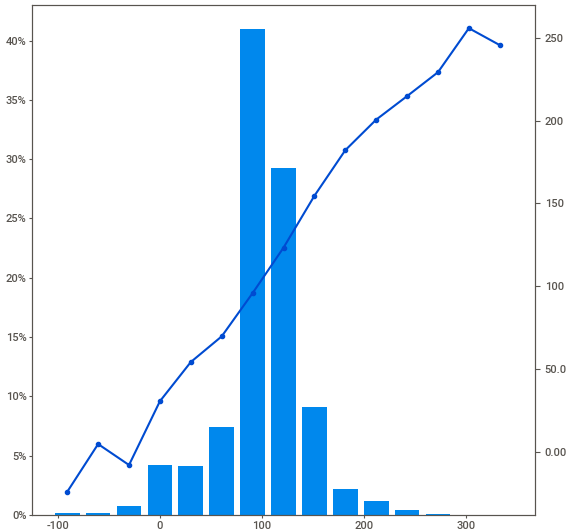
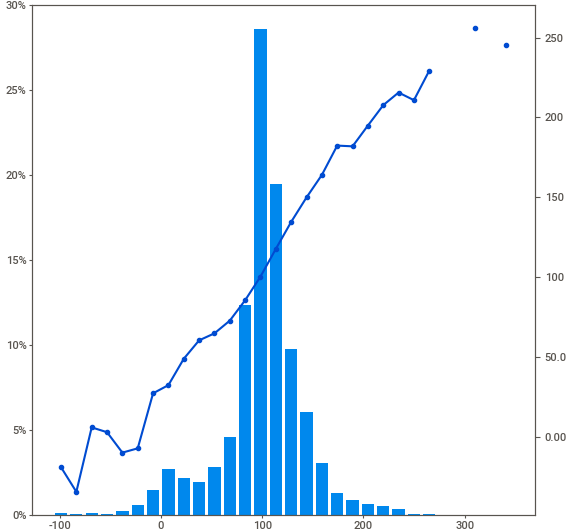
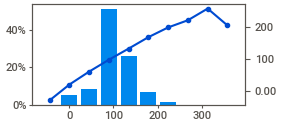
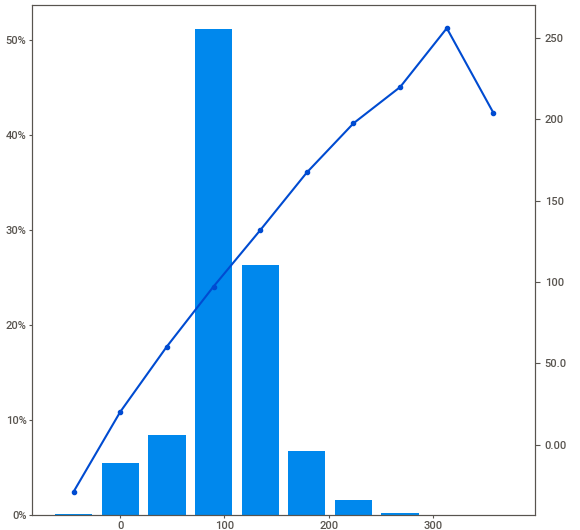
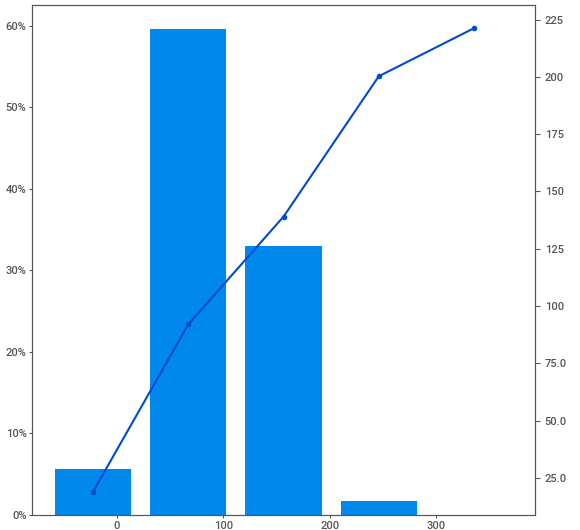
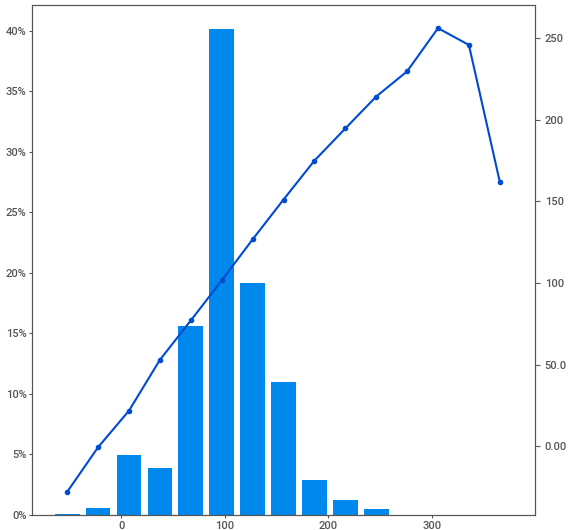
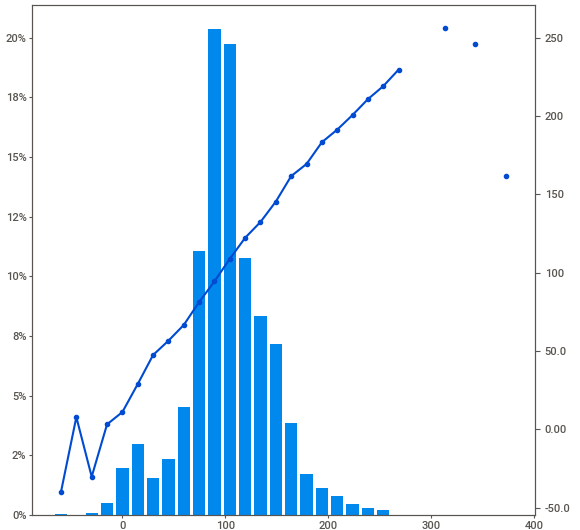
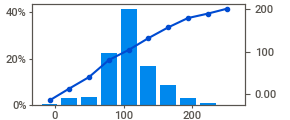
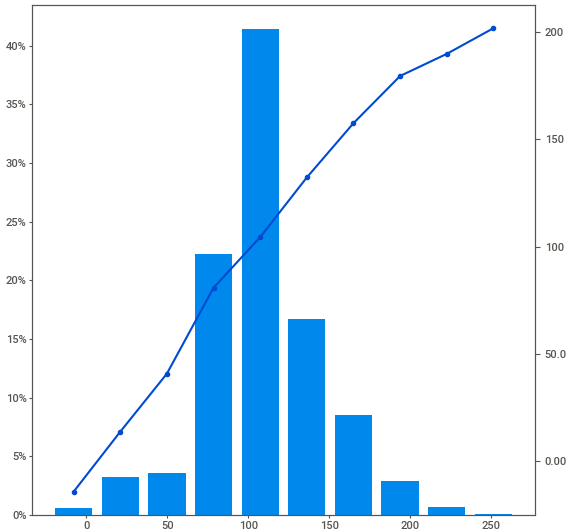
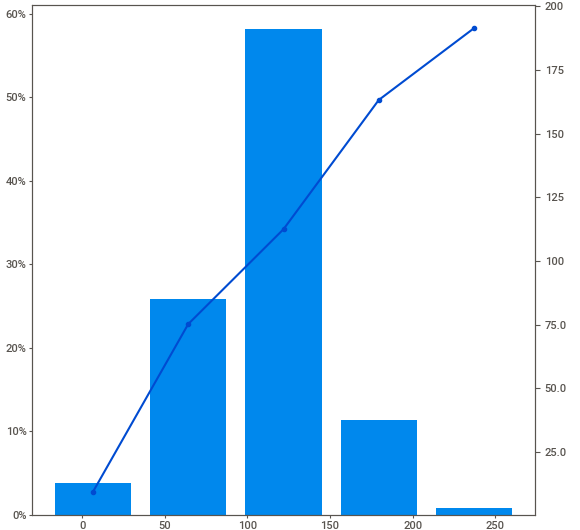
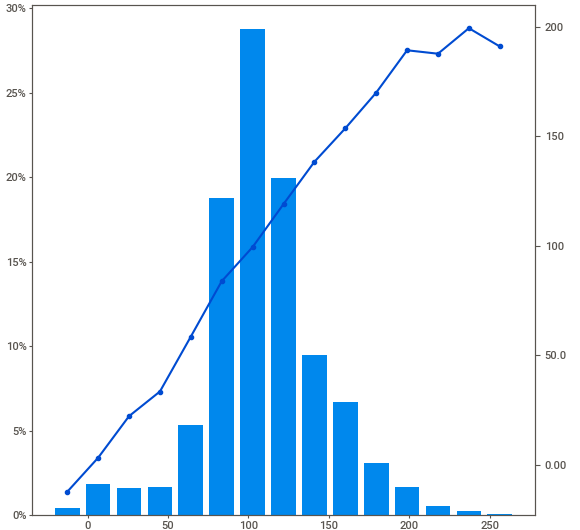
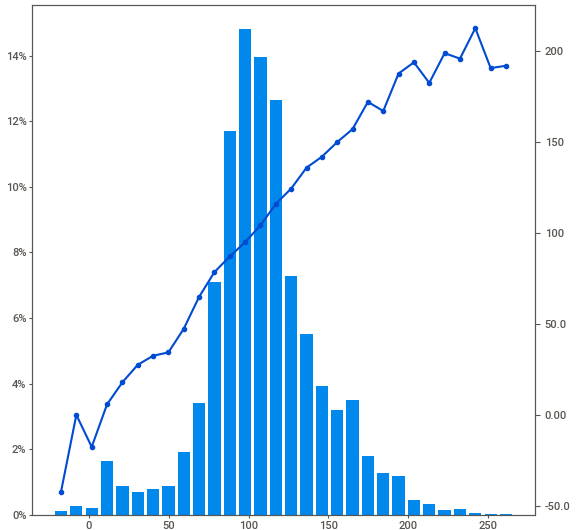
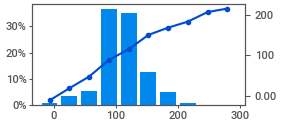
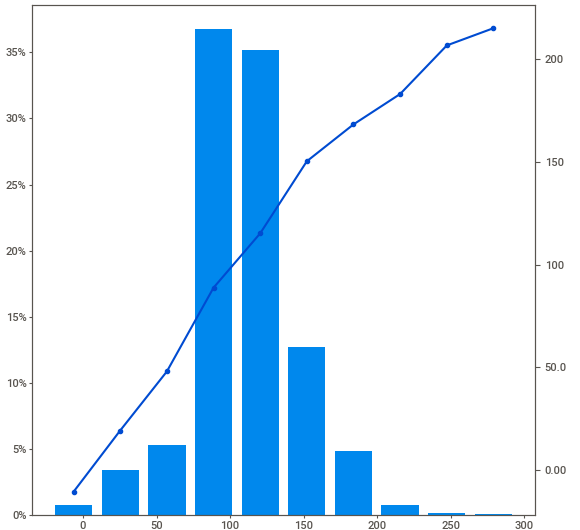
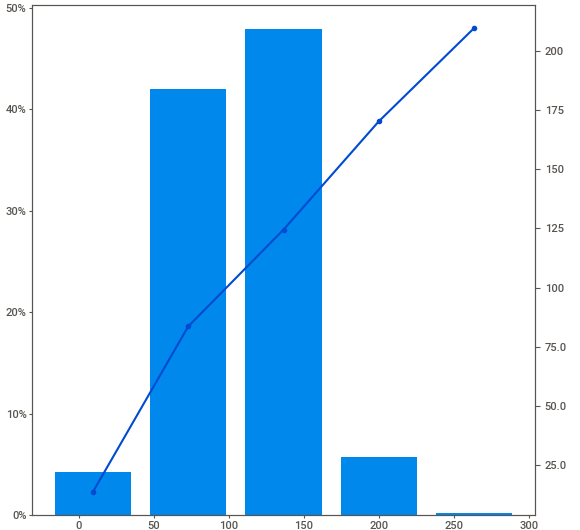
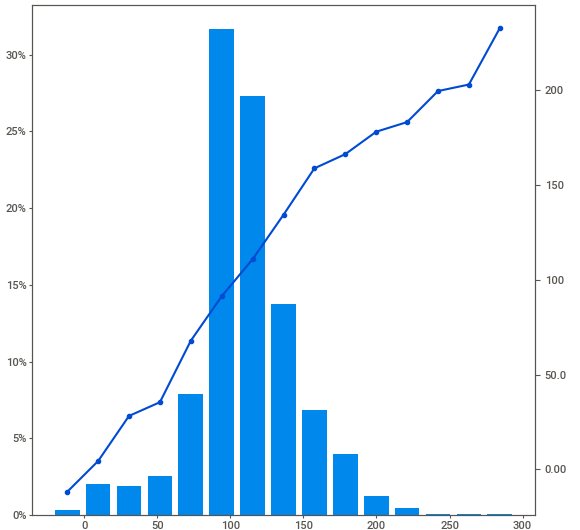
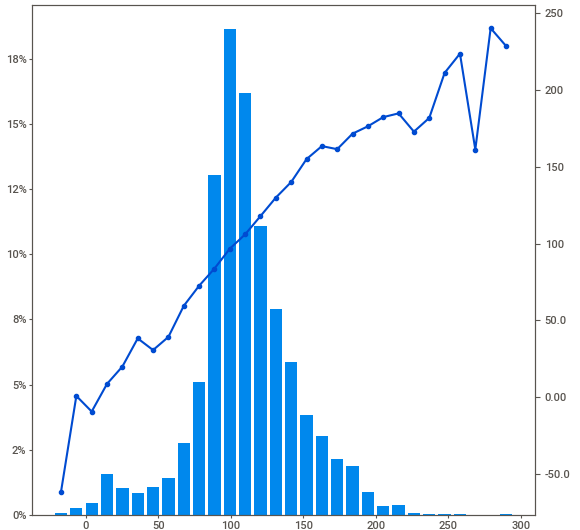
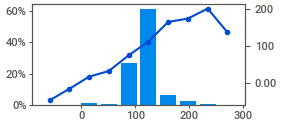
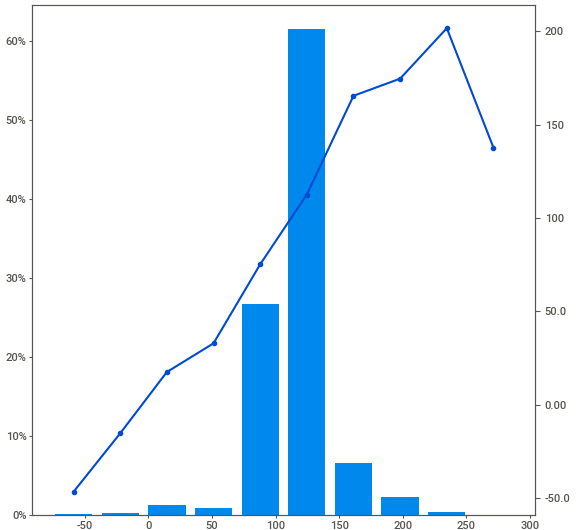
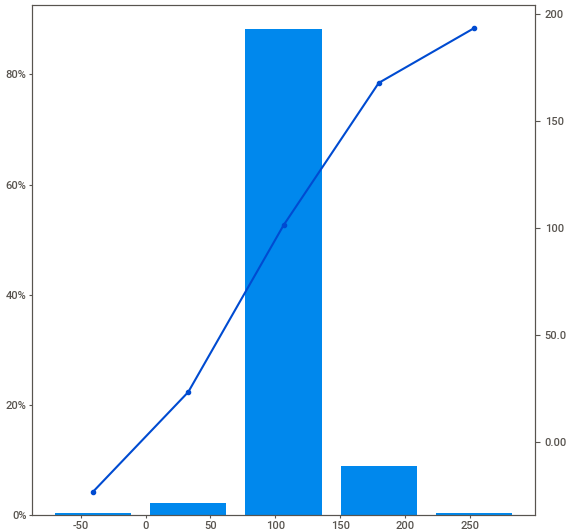
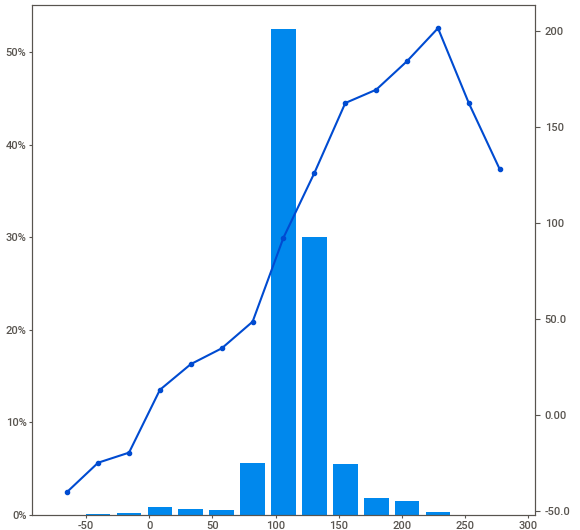
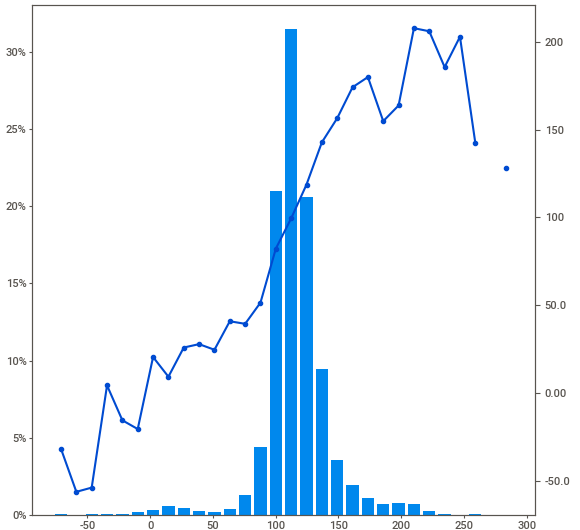
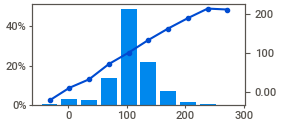
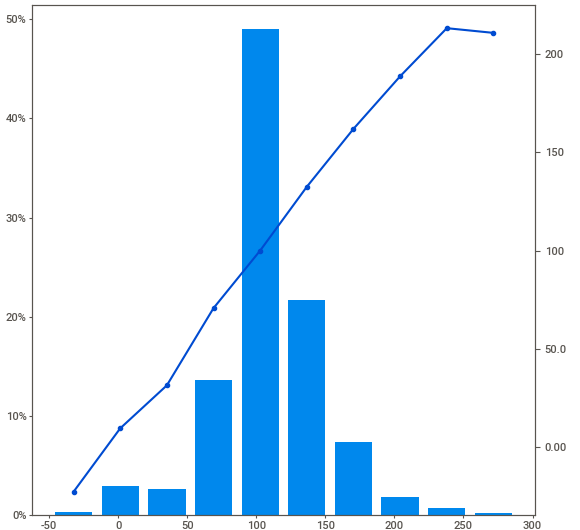
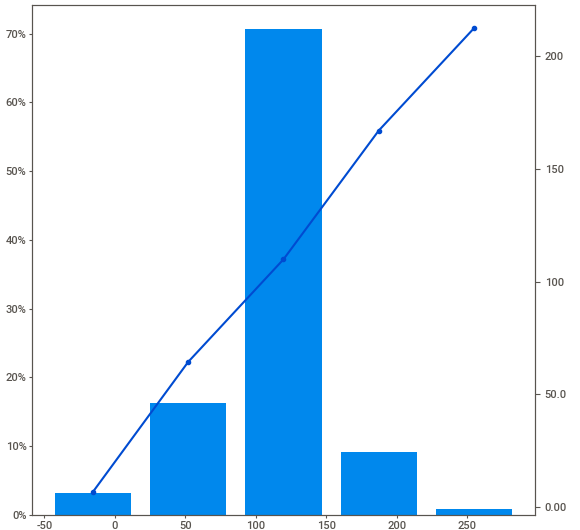
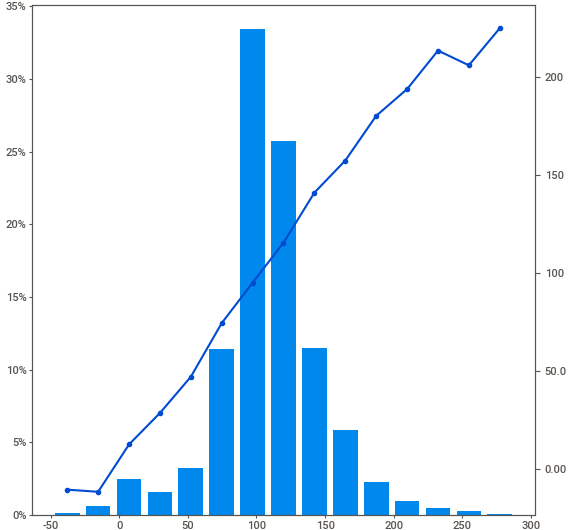
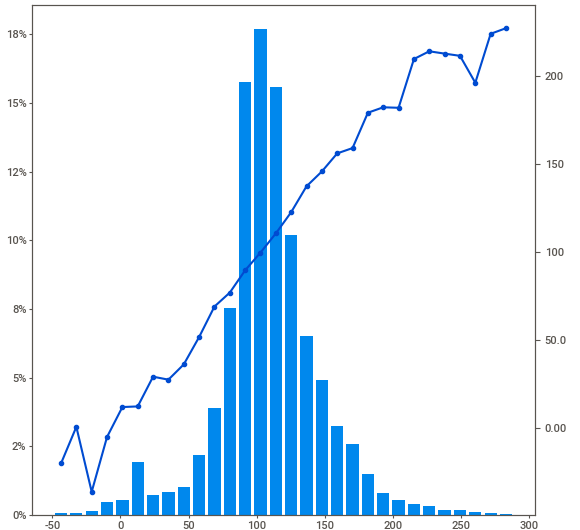
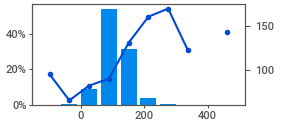
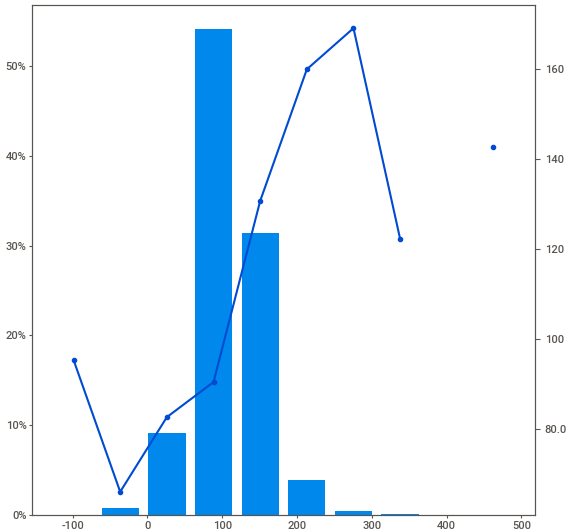
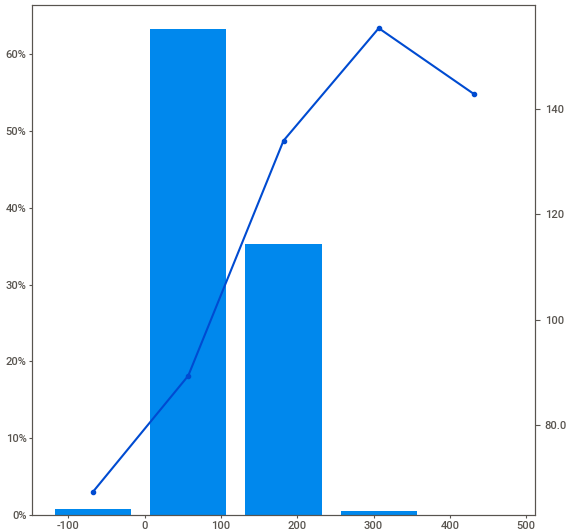
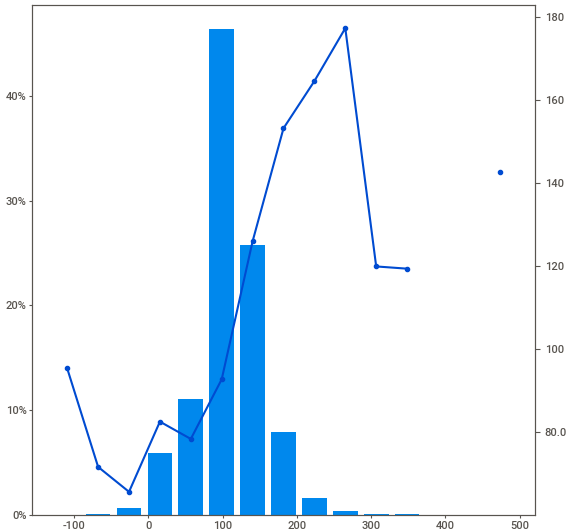
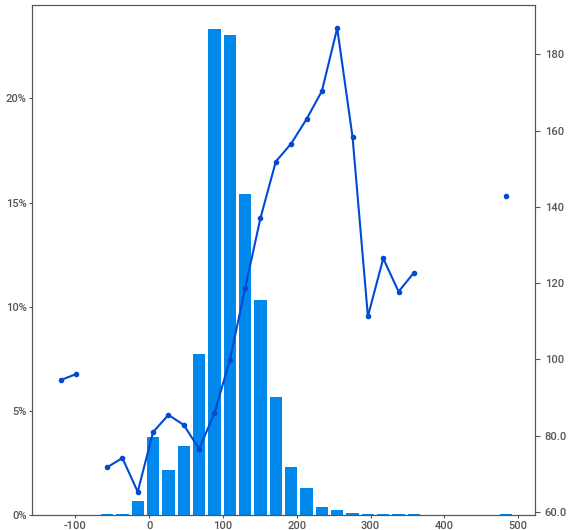
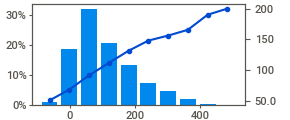
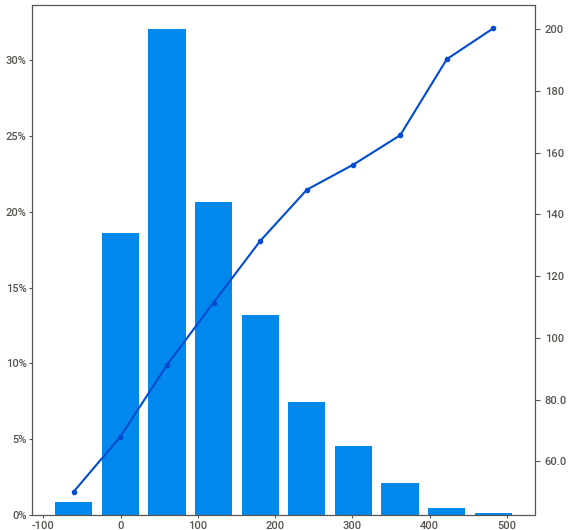
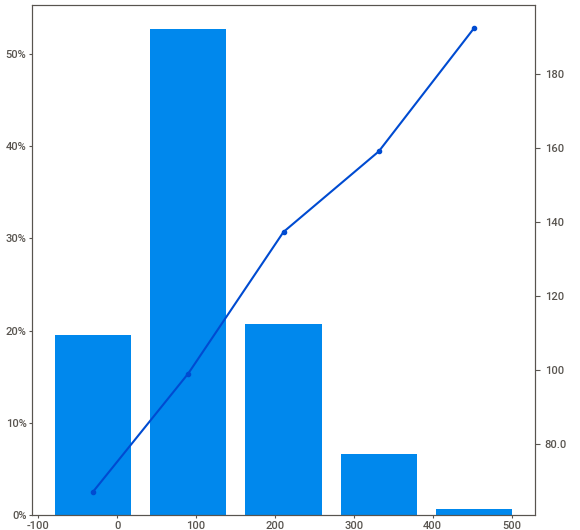
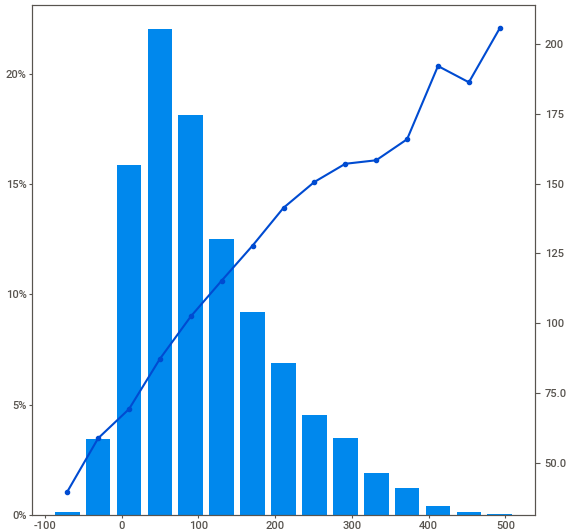
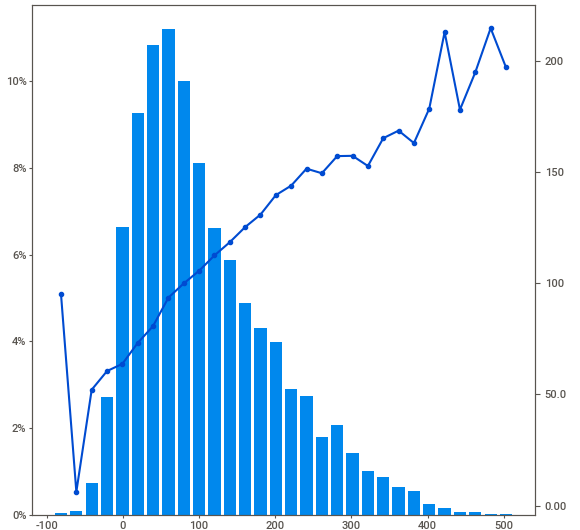
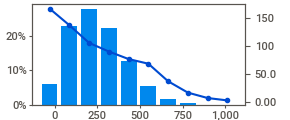
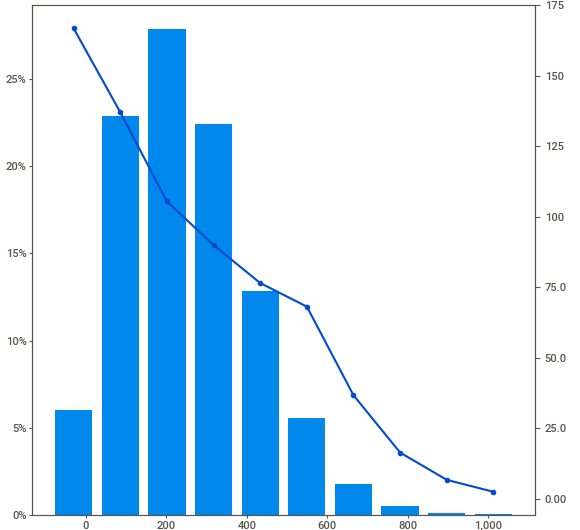
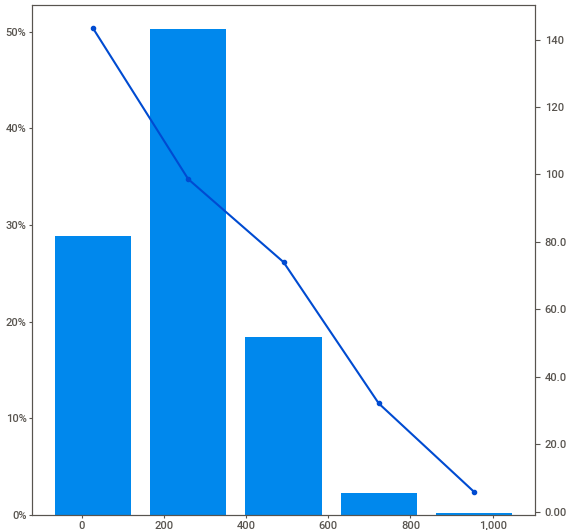
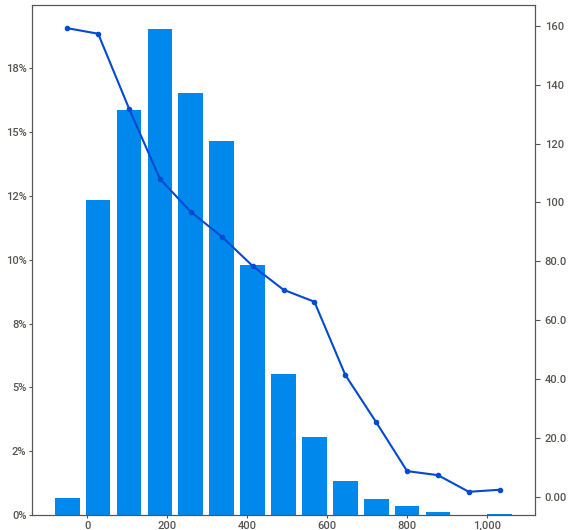
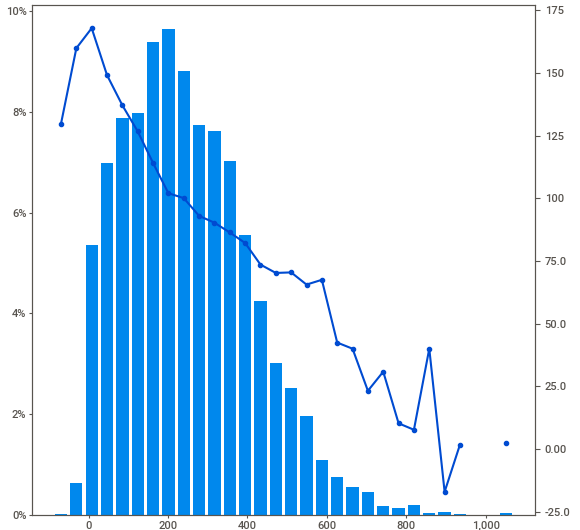
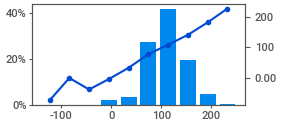
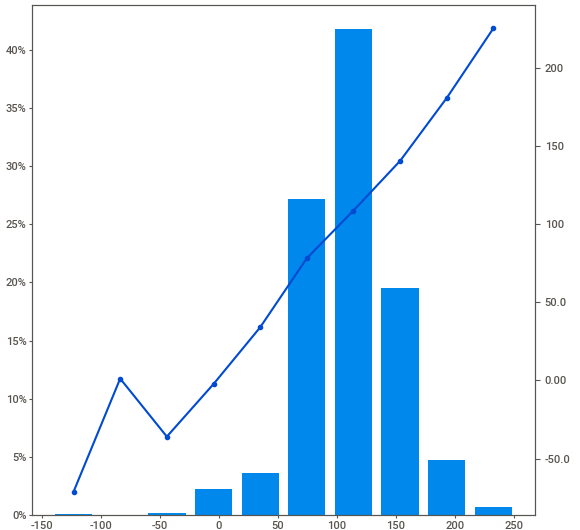
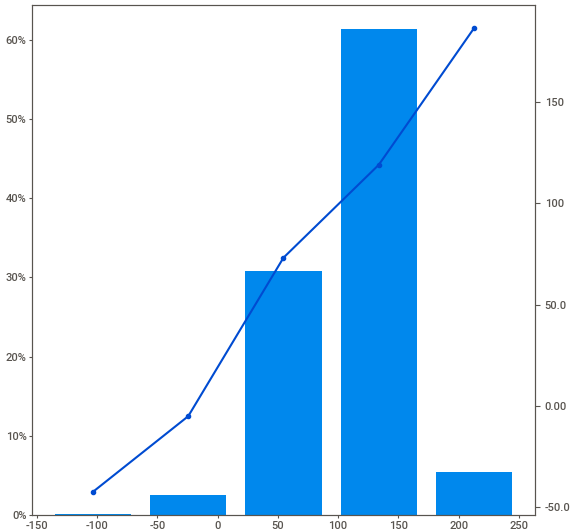
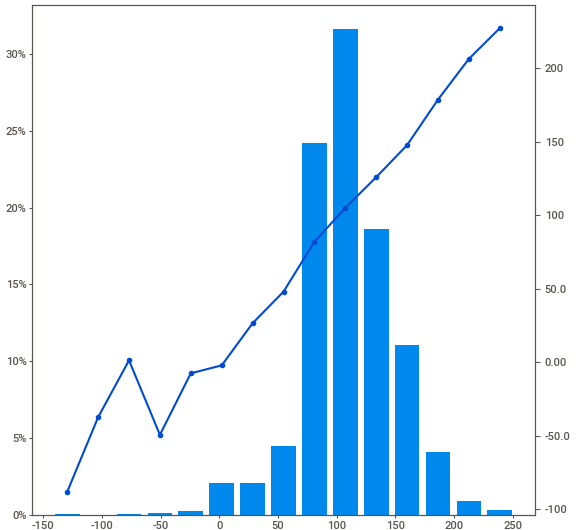
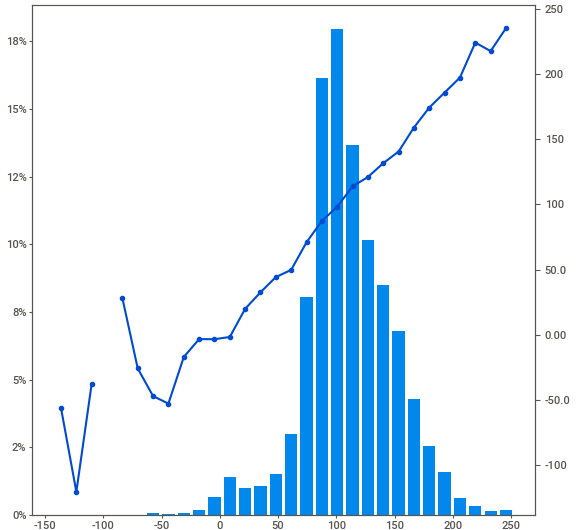
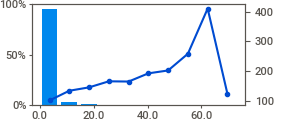
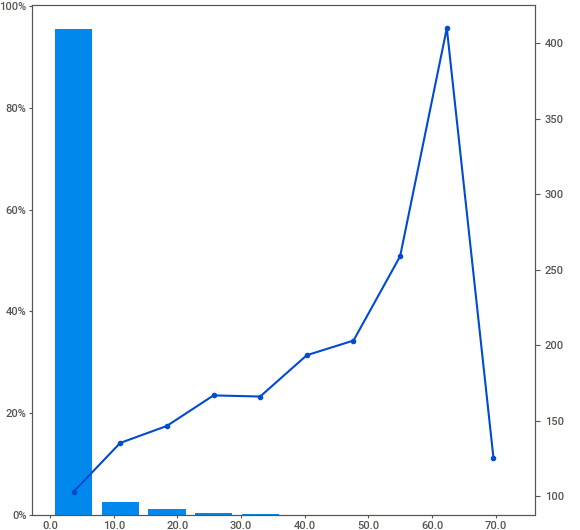
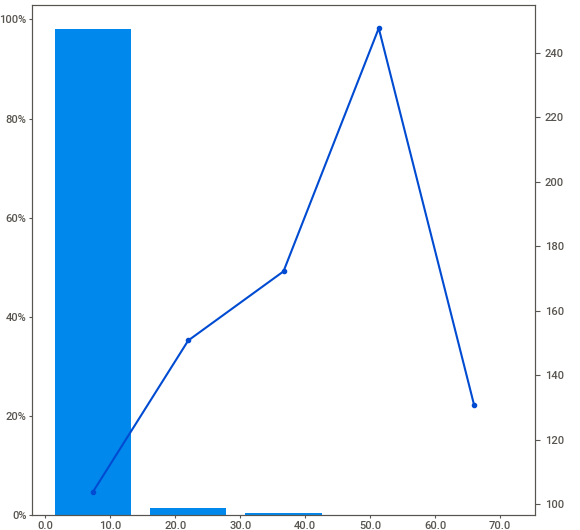
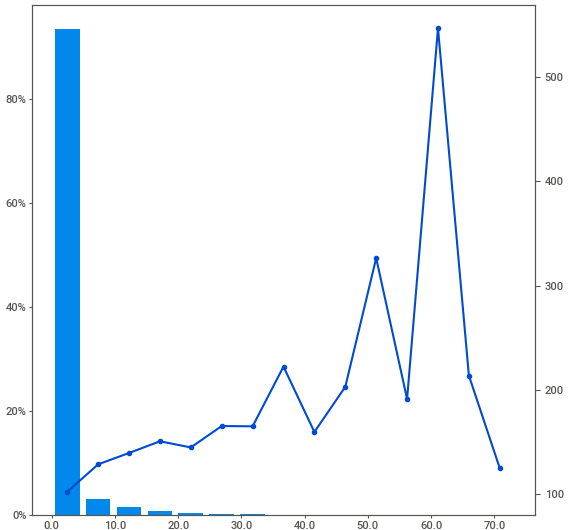
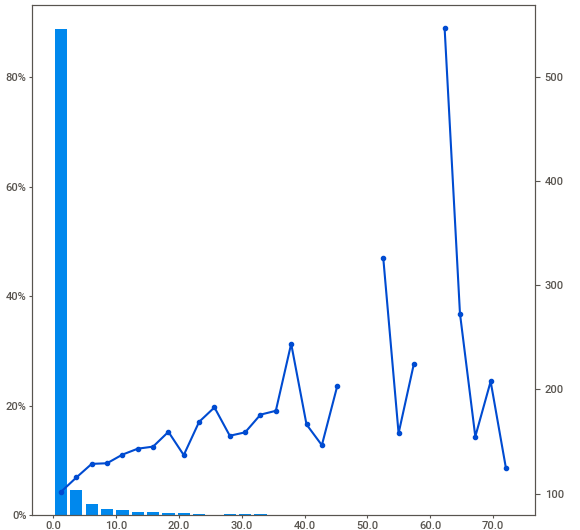
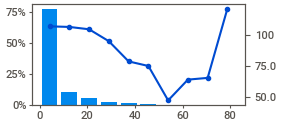
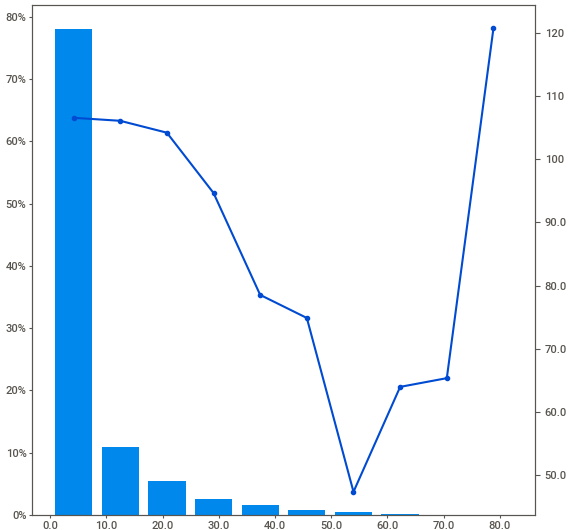
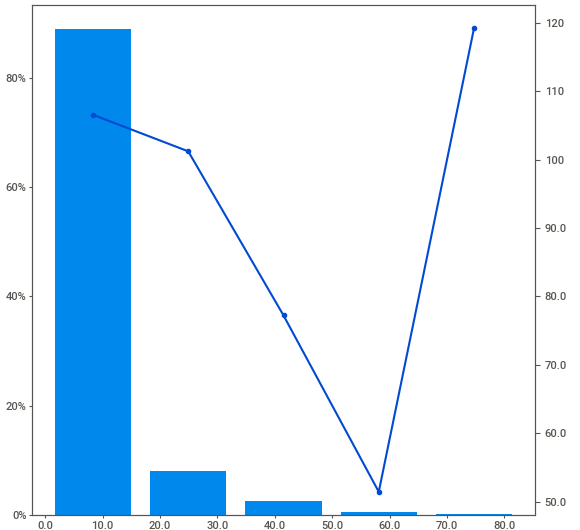
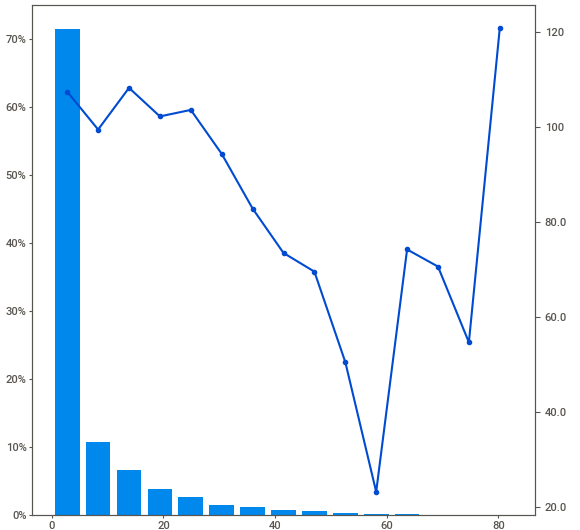
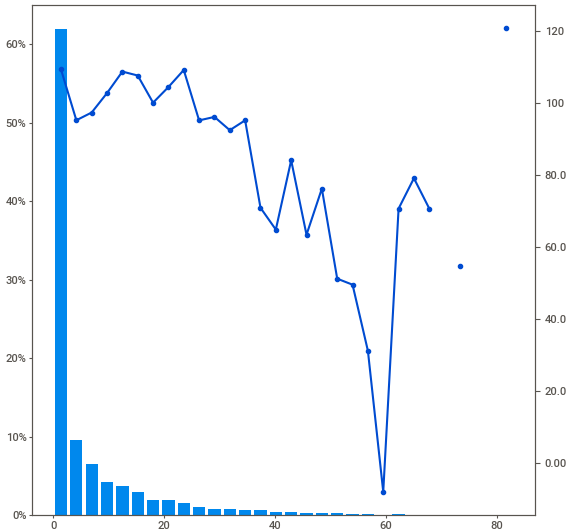
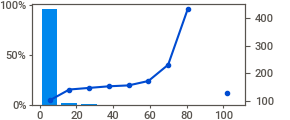
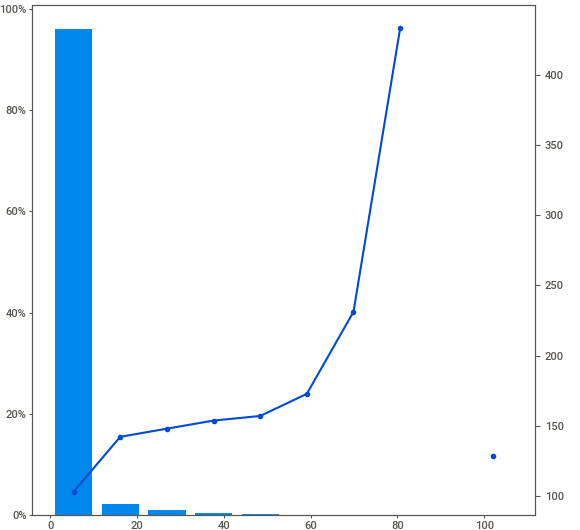
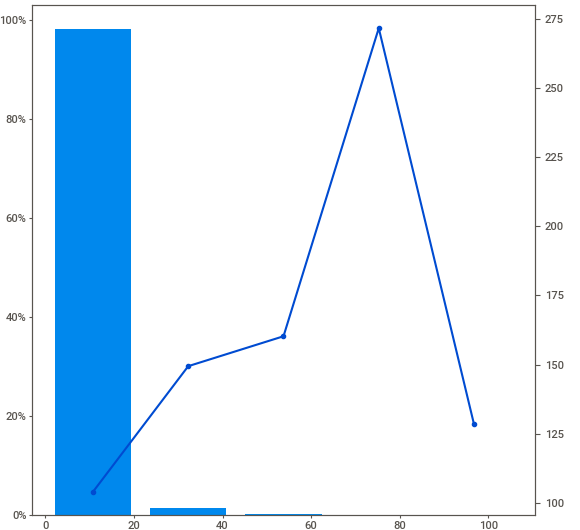
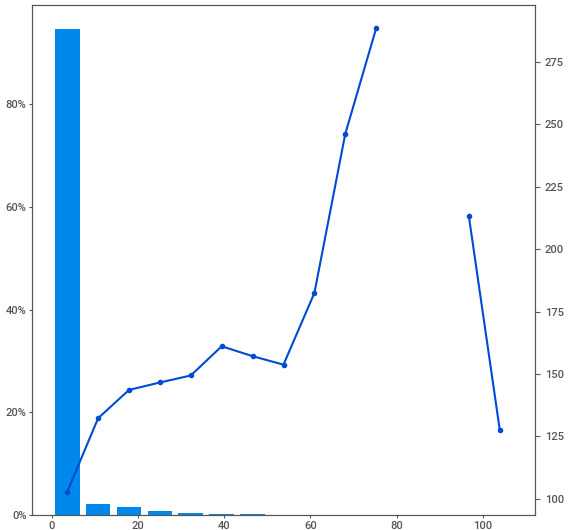
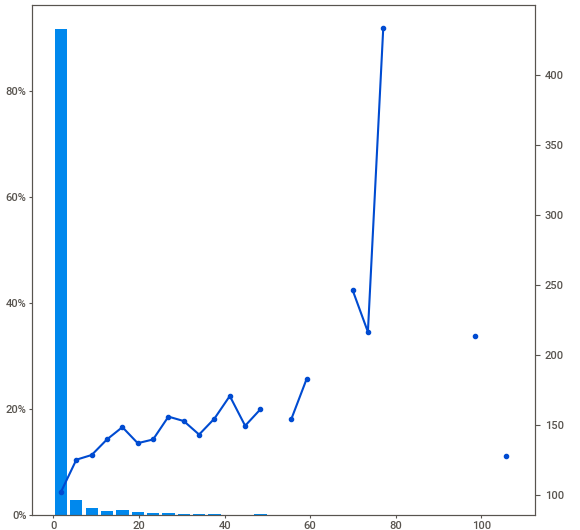
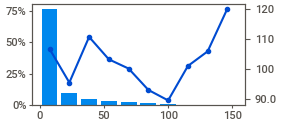
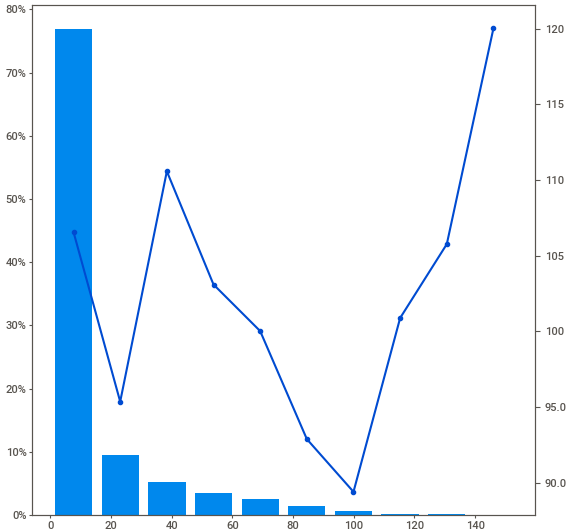
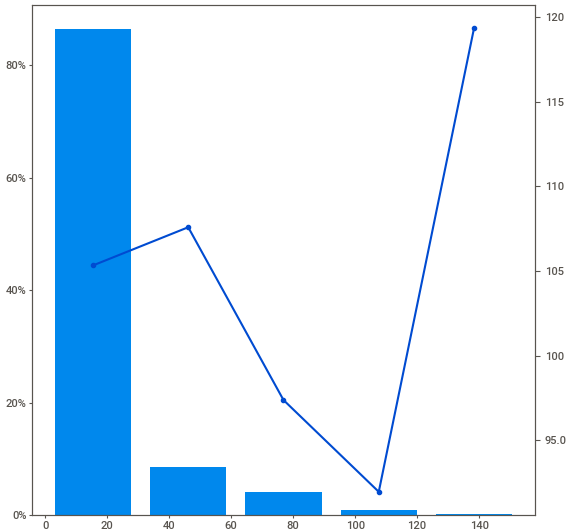
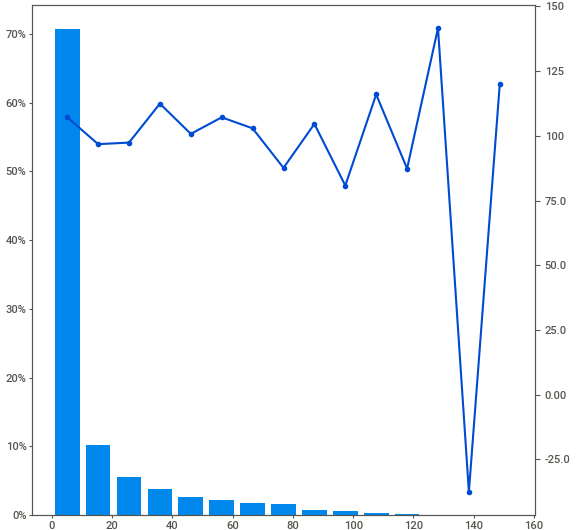
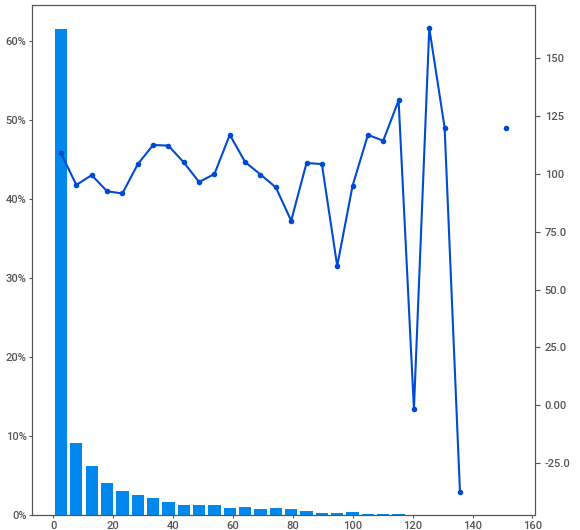
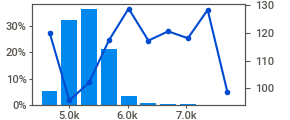
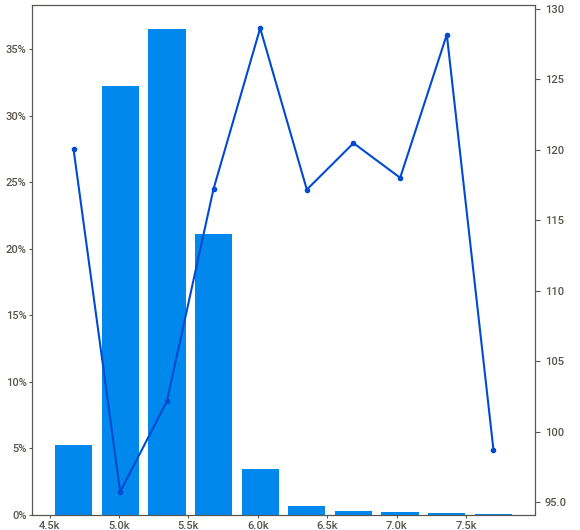
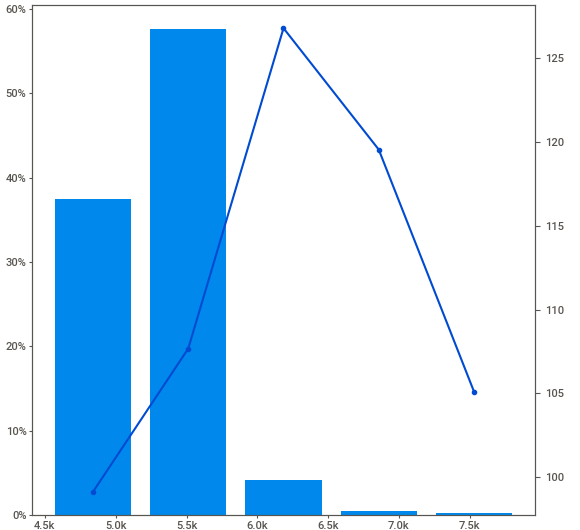
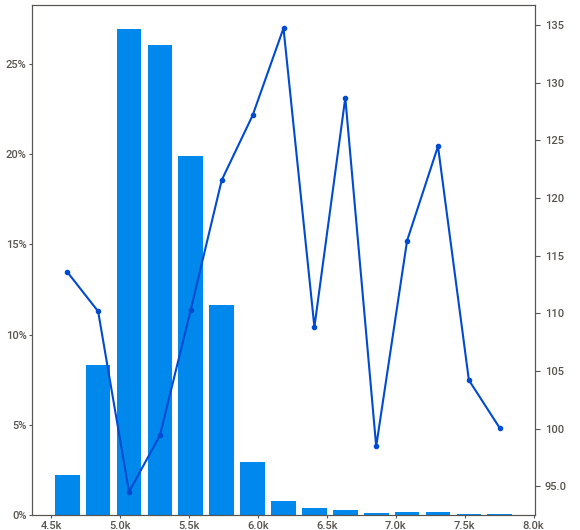
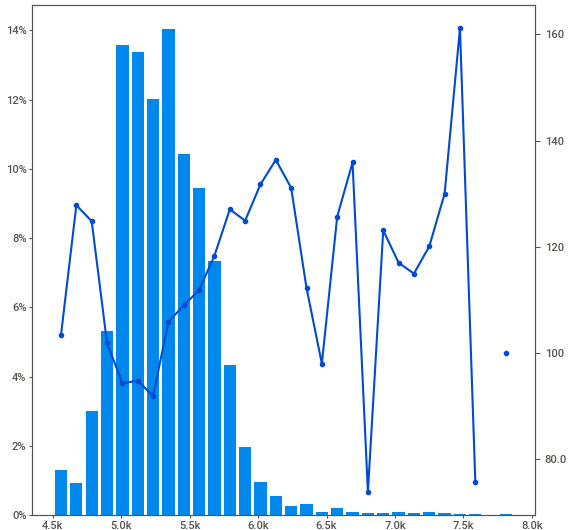
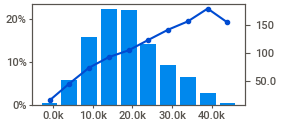
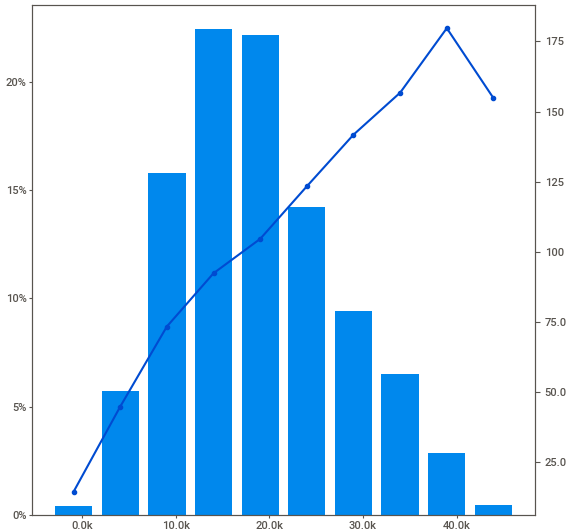
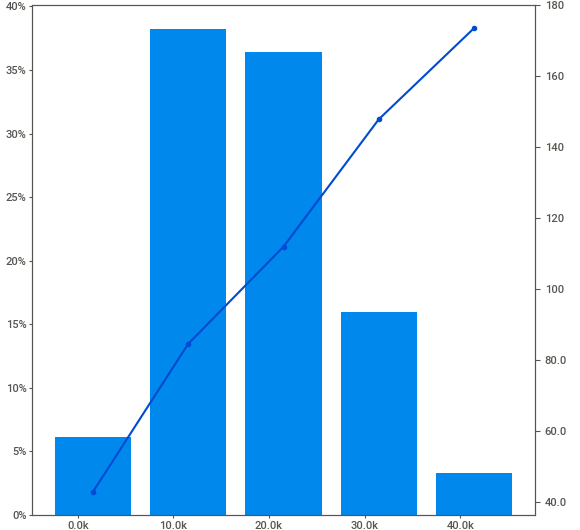
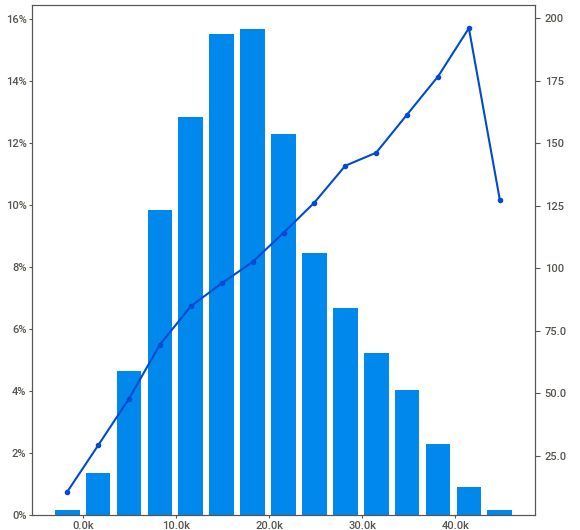
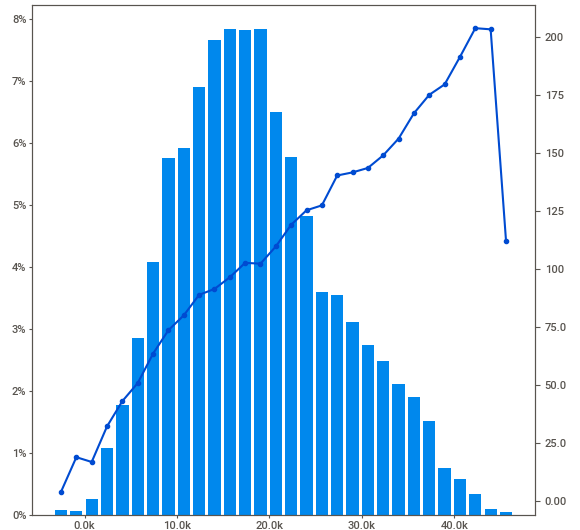
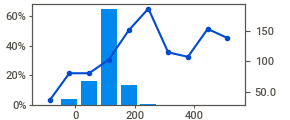
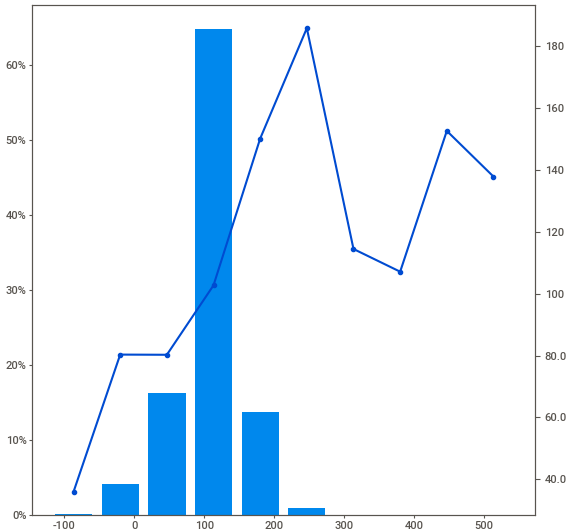
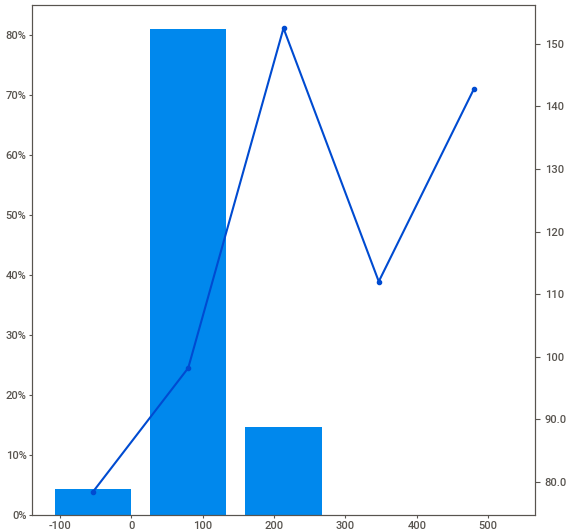
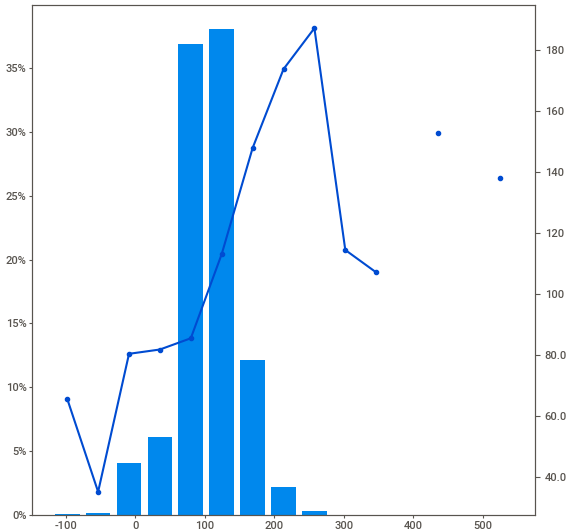
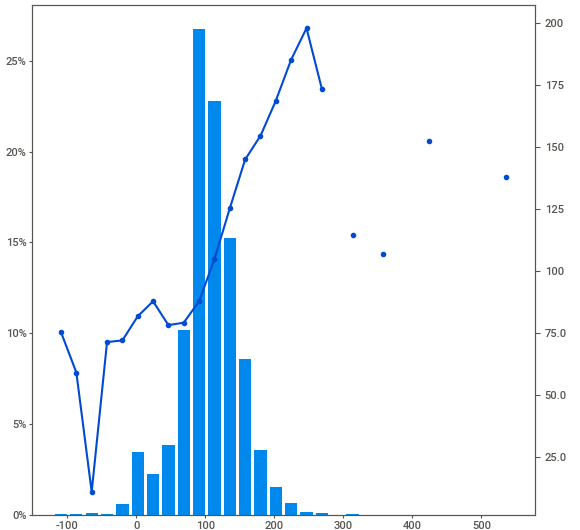
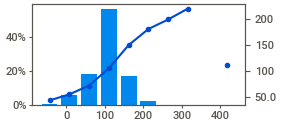
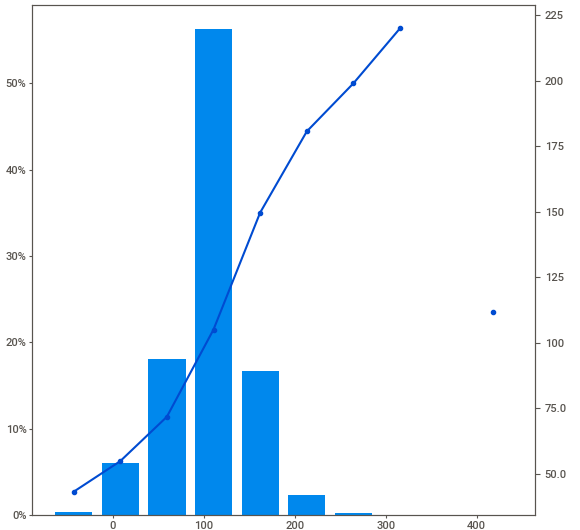
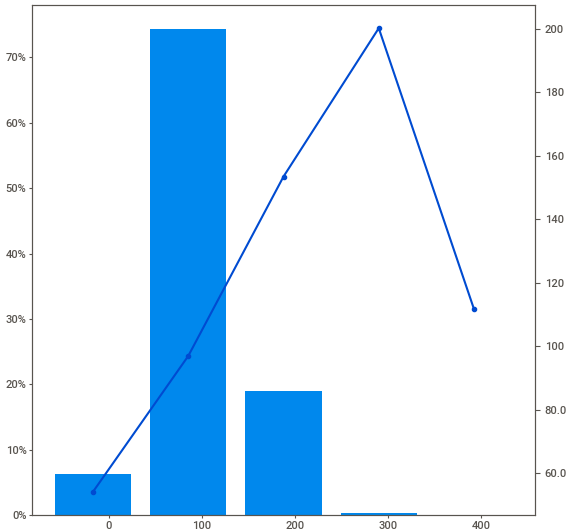
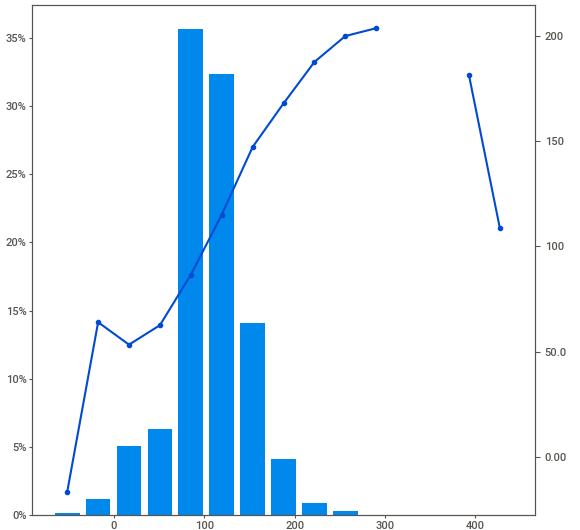
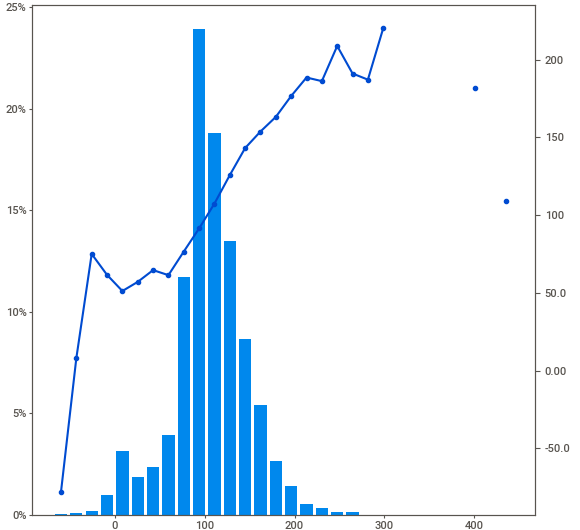
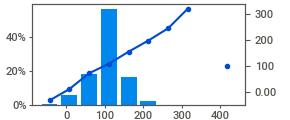
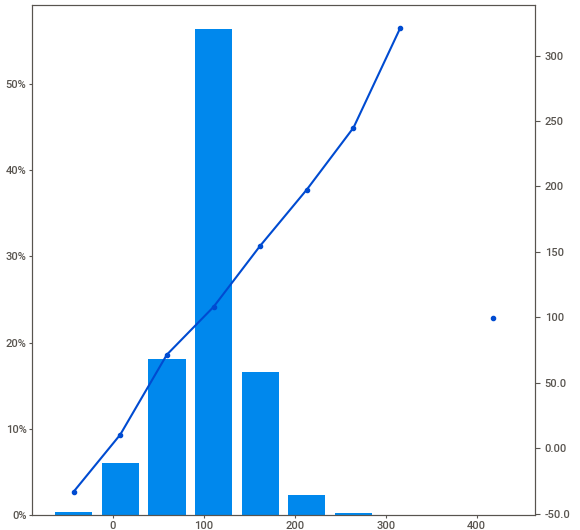
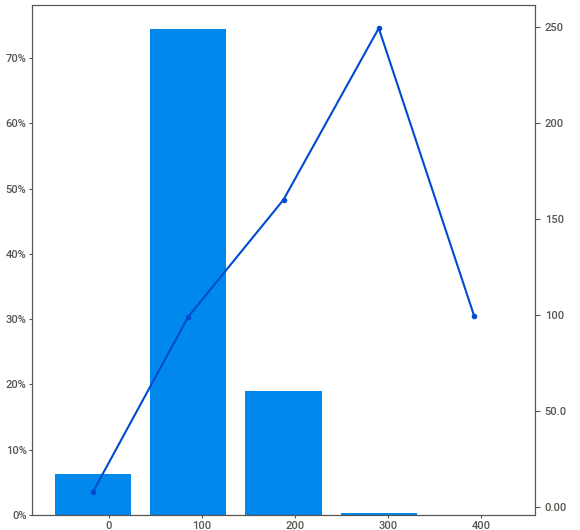
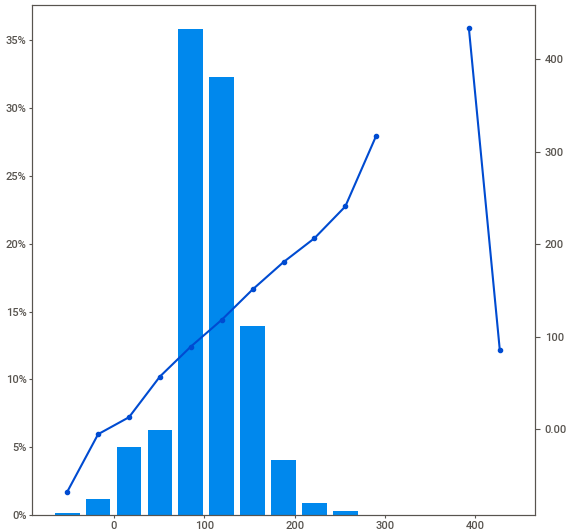
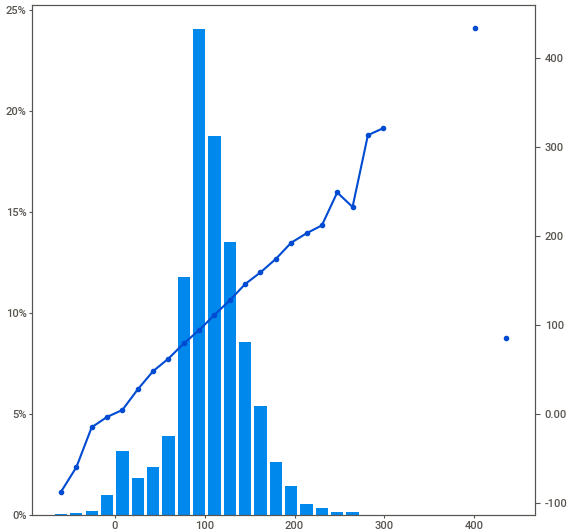
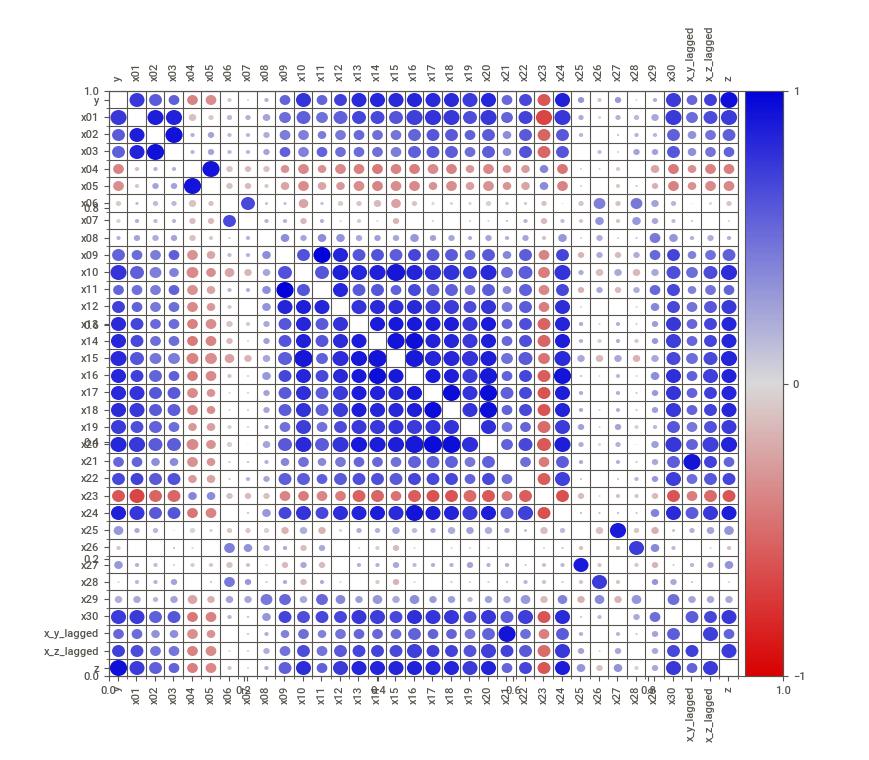
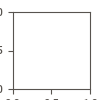

In [15]:
report.show_notebook()

# AD HOC

## what is the lag


whats the lag size?

In [16]:
red = df[["date","x_y_lagged", "y"]]

days_to_take = 3
start_date = df["date"].min().date() + pd.Timedelta(days=1) #add one day as begining of data seems to be corrupted
end_date = start_date + pd.Timedelta(days=days_to_take)

red = red[(red['date'].dt.date >= start_date) & (red['date'].dt.date <= end_date)]

red['hour'] = red['date'].dt.hour

red.to_excel(f"{INTERIM_FOLDER}/reduced.xlsx", index=False)

In [17]:
pivot_df = red.pivot_table(index='hour', columns=df['date'].dt.date, values=['y', 'x_y_lagged'])
pivot_df

x_y_lagged                                           y             \
date 2023-01-17 2023-01-18 2023-01-19 2023-01-20 2023-01-17 2023-01-18   
hour                                                                     
0         67.01      49.03      84.83     110.82      84.83     110.82   
1         27.99      66.99     102.78      92.73     102.78      92.73   
2         58.68      63.03      95.64      53.79      95.64      53.79   
3         29.66      66.85      93.85     118.21      93.85     118.21   
4         10.46      64.96      87.44      98.45      87.44      98.45   
5         10.99      63.42      91.92      93.38      91.92      93.38   
6         14.86      95.30      99.48      94.83      99.48      94.83   
7         22.88     166.52     129.57     133.55     129.57     133.55   
8         50.65     179.21     159.55     170.92     159.55     170.92   
9        118.54     182.54     183.88     164.90     183.88     164.90   
10       119.99     165.13     155.69     181.47     155.69     181.47   
11       125.66     175.64     147.72     154.11     147.72     154.11   
12       125.85     174.99     140.00      64.86     140.00      64.86   
13       121.65     153.38     131.21     143.20     131.21     143.20   
14        95.82     146.33     140.89     158.14     140.89     158.14   
15       100.63     143.51     157.30     139.48     157.30     139.48   
16        99.55     151.86     175.53     159.45     175.53     159.45   
17        95.32     152.00     182.35     159.70     182.35     159.70   
18       126.30     177.99     175.21     163.57     175.21     163.57   
19       121.25     165.08     164.48     150.06     164.48     150.06   
20       128.22     125.00     163.92     159.99     163.92     159.99   
21       124.04     151.05     155.99     161.17     155.99     161.17   
22       103.75     127.97     150.65     141.66     150.65     141.66   
23       112.22     110.73     128.18     101.09     128.18     101.09   

                            
date 2023-01-19 2023-01-20  
hour                        
0         86.46      79.77  
1         91.68     131.60  
2         70.13      71.70  
3         70.86     149.20  
4         99.80     100.16  
5         98.51     146.75  
6        108.99     110.01  
7        130.32     180.80  
8        165.47     209.33  
9        161.00     203.81  
10       168.76     210.32  
11       156.70     150.51  
12       156.20     128.29  
13       200.05     191.60  
14       146.49     199.99  
15        72.93     226.88  
16       161.78     215.20  
17       181.33     208.00  
18       185.70     230.01  
19       185.94     209.88  
20       187.63     199.02  
21       197.39     177.54  
22       155.76     151.90  
23        71.69     146.58

## conclusions

1. begining of data seems to be corrupted
2. lag seems to be exactly 2 days, i.e. according to data at time *n* of day *D* we know what was the value of *y* 2 days before
3. missing values have to be explained